In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import warnings 
warnings.filterwarnings(action='ignore') 
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.9):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [3]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col=0)
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col=0)


print("train: ", train.shape)
print("test: ", test.shape)
train.head()

train:  (1460, 80)
test:  (1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [4]:
X = pd.concat([train.drop("SalePrice", axis=1),test], axis=0)
y = train[['SalePrice']]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(X)

Observations: 2919
Variables: 79
cat_cols: 52
num_cols: 26
cat_but_car: 1
num_but_cat: 10


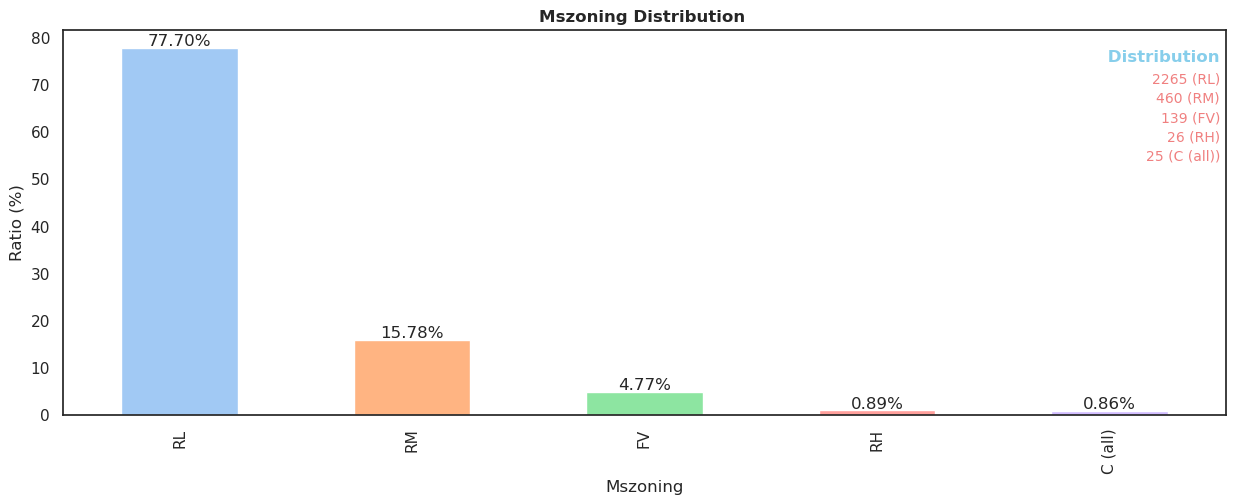

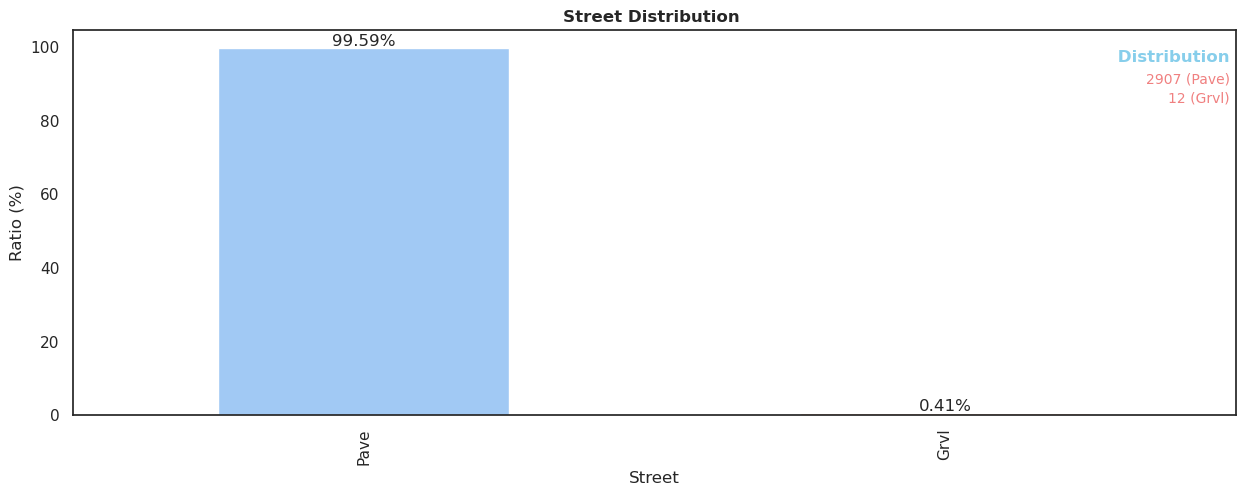

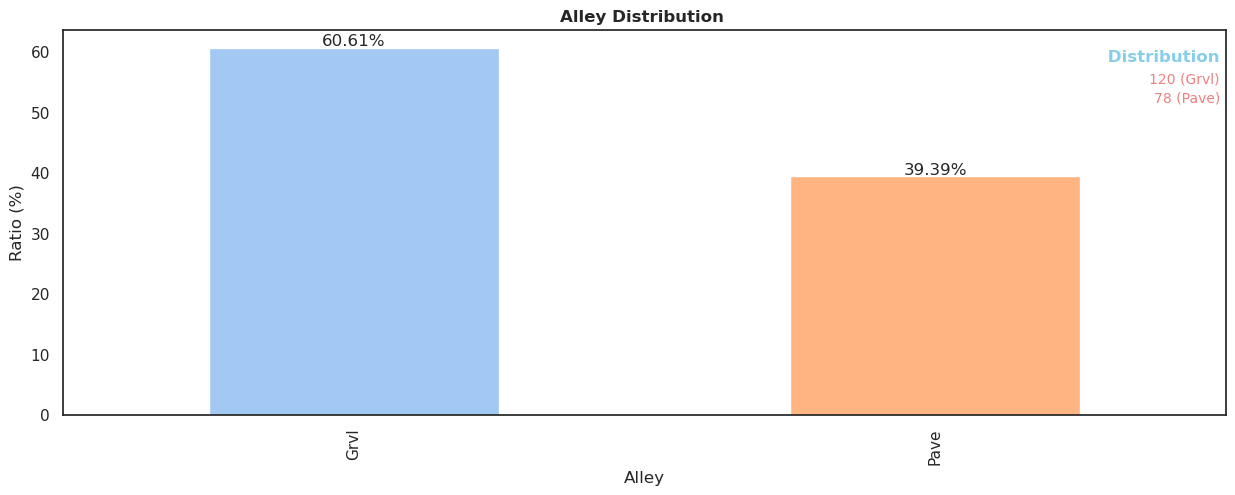

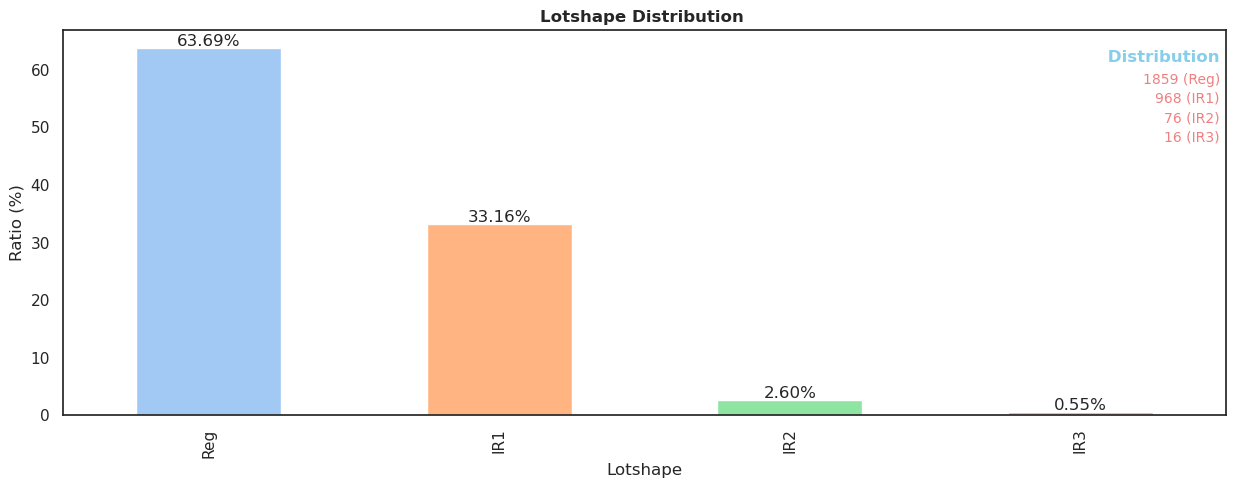

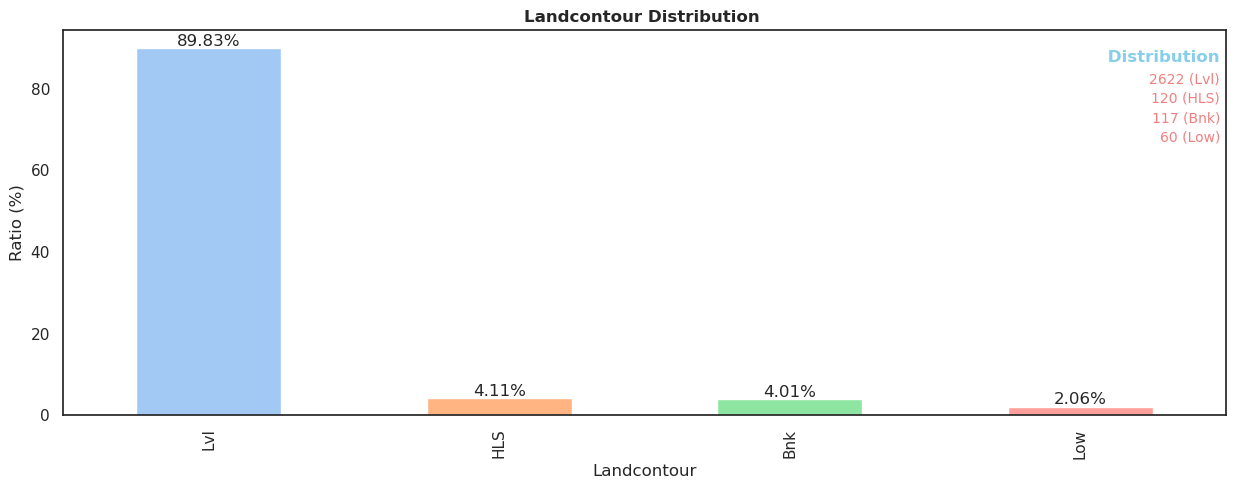

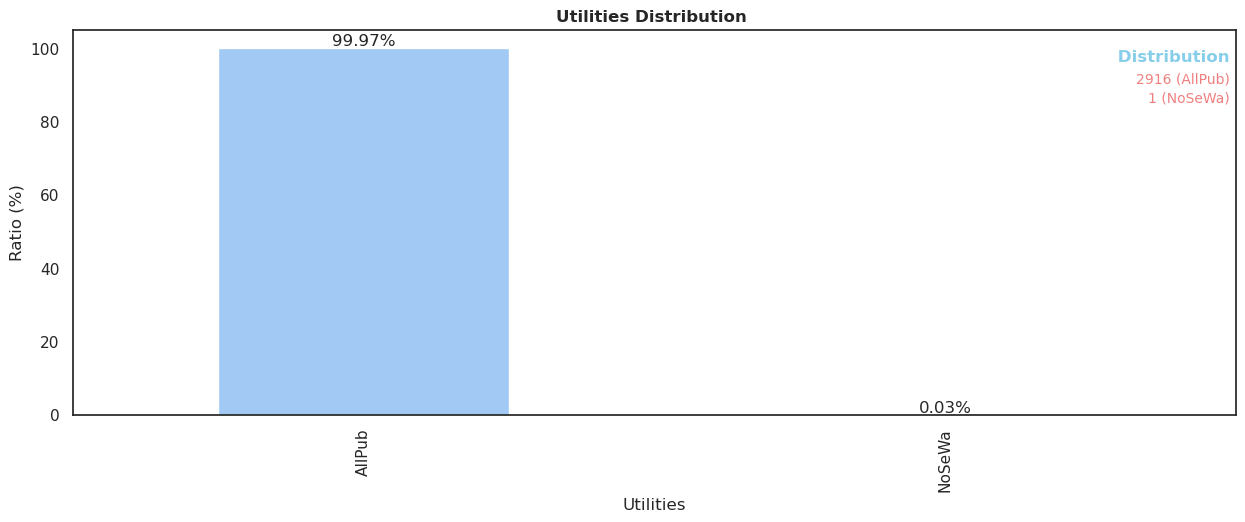

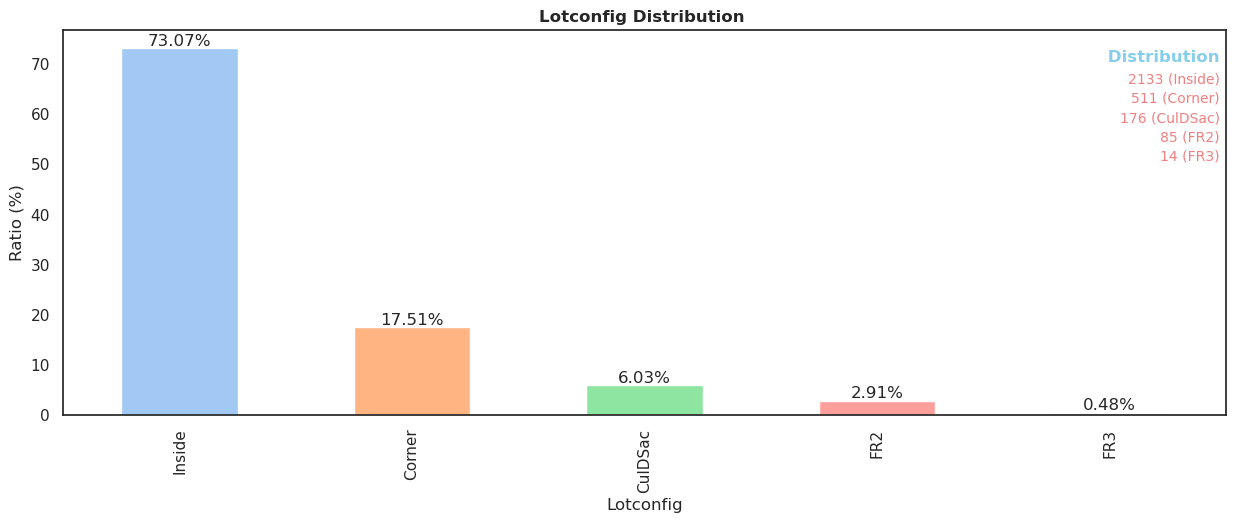

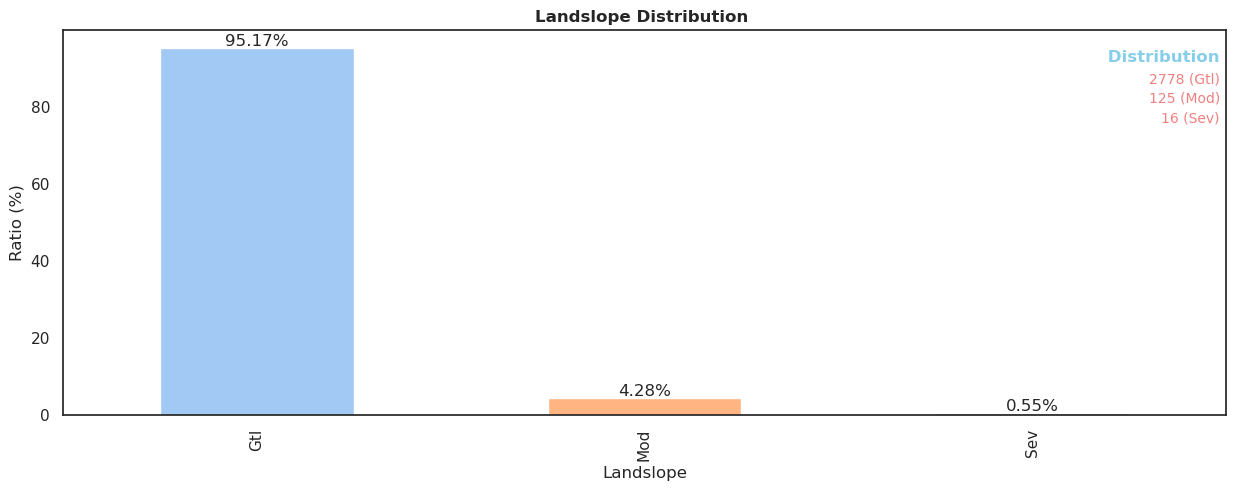

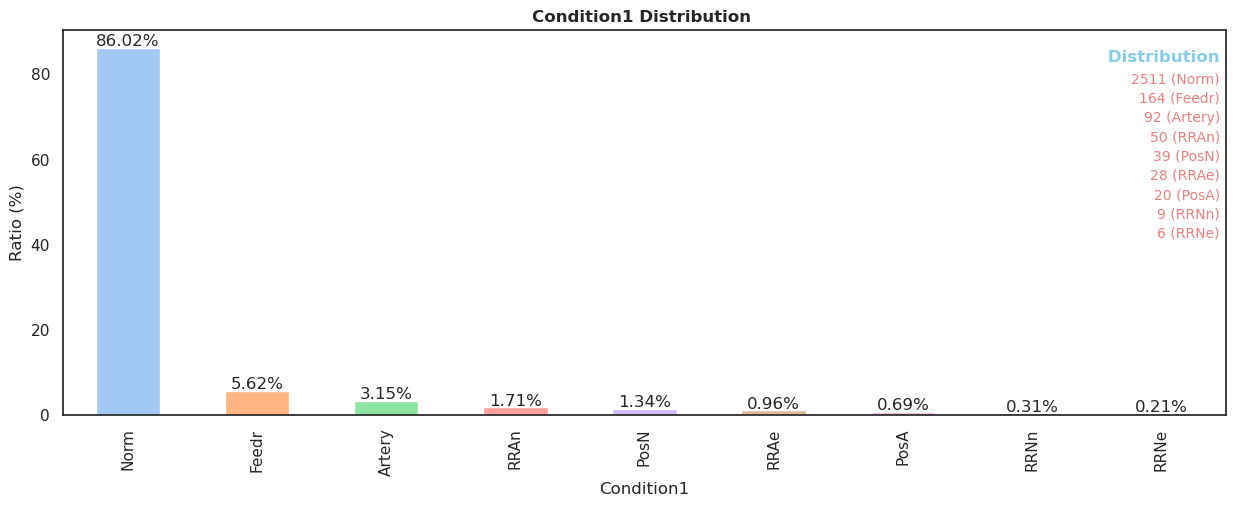

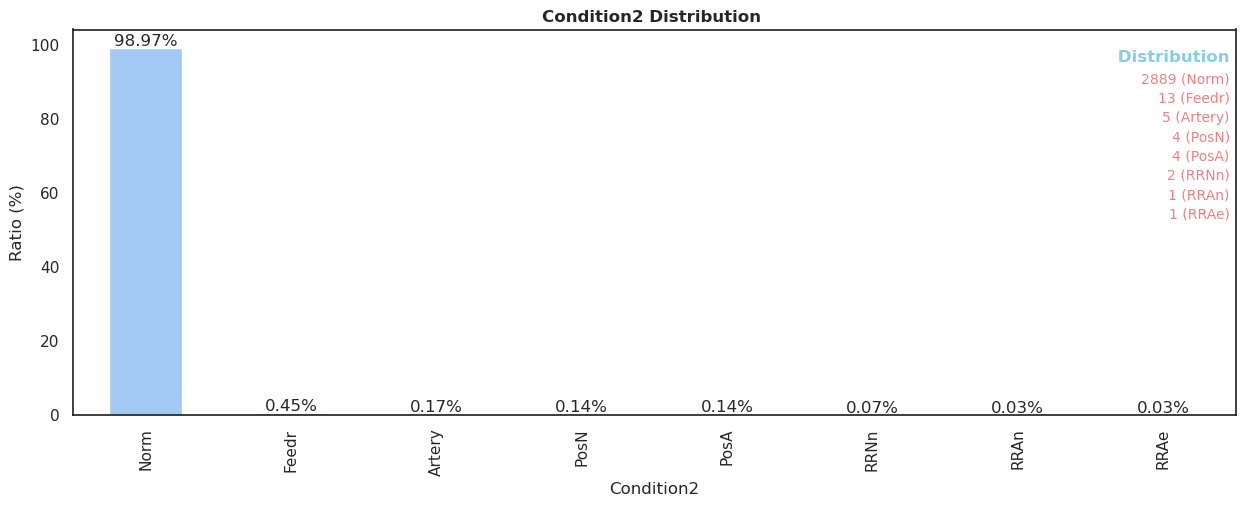

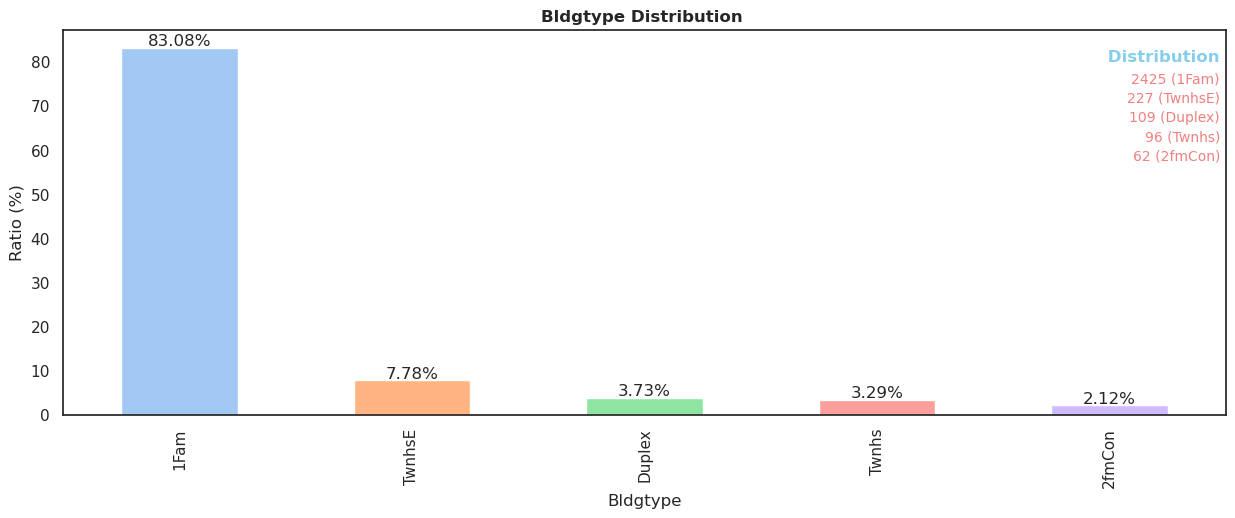

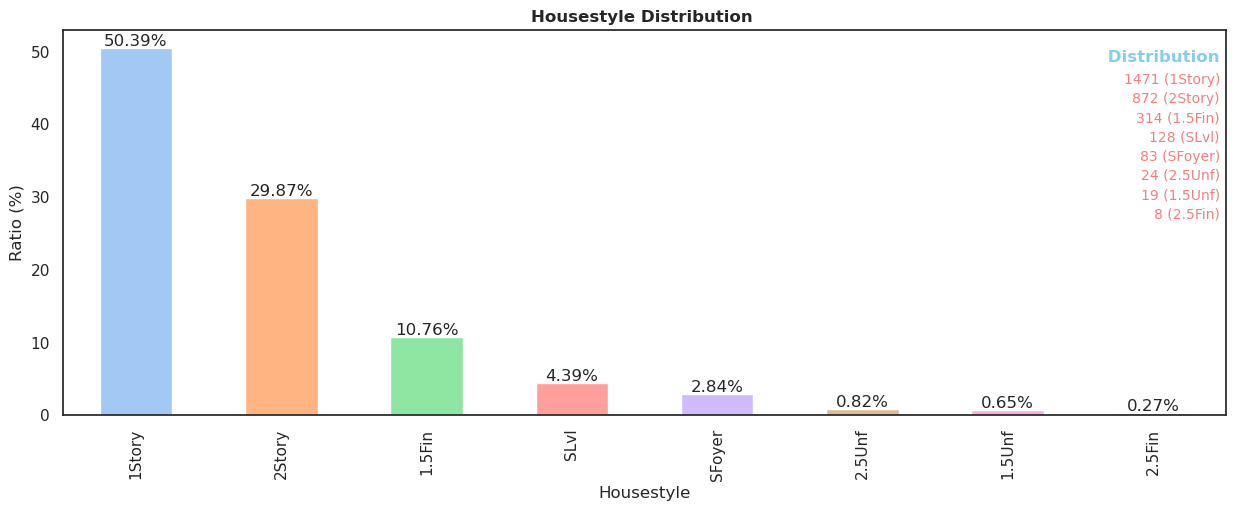

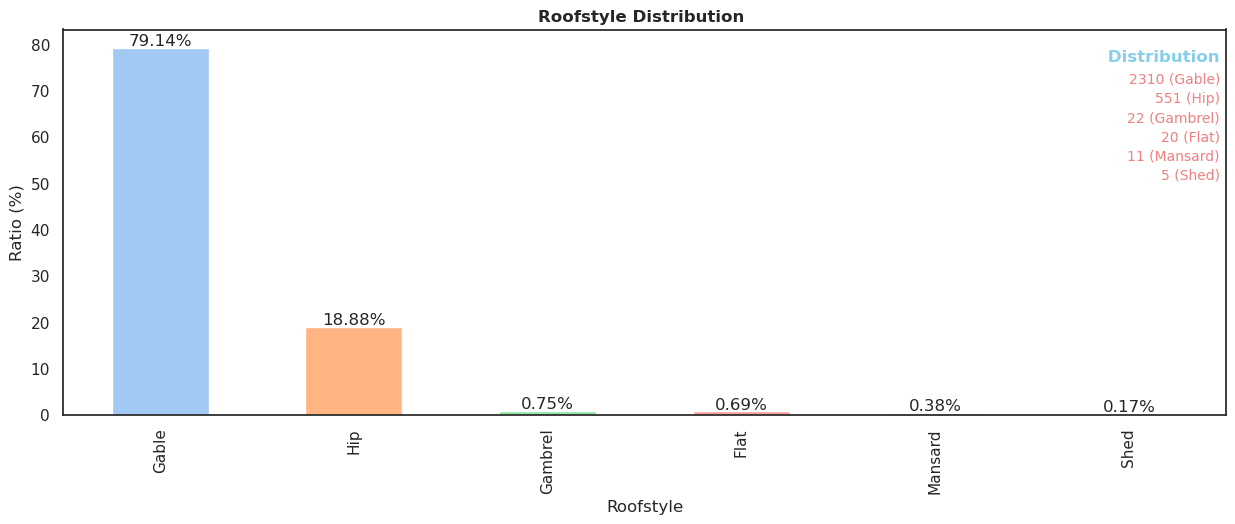

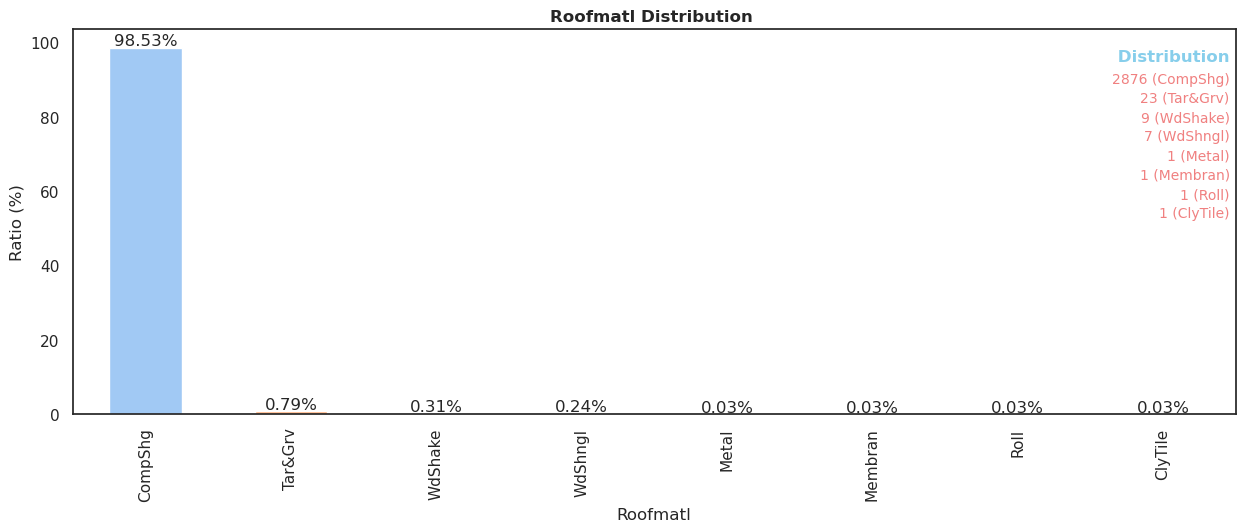

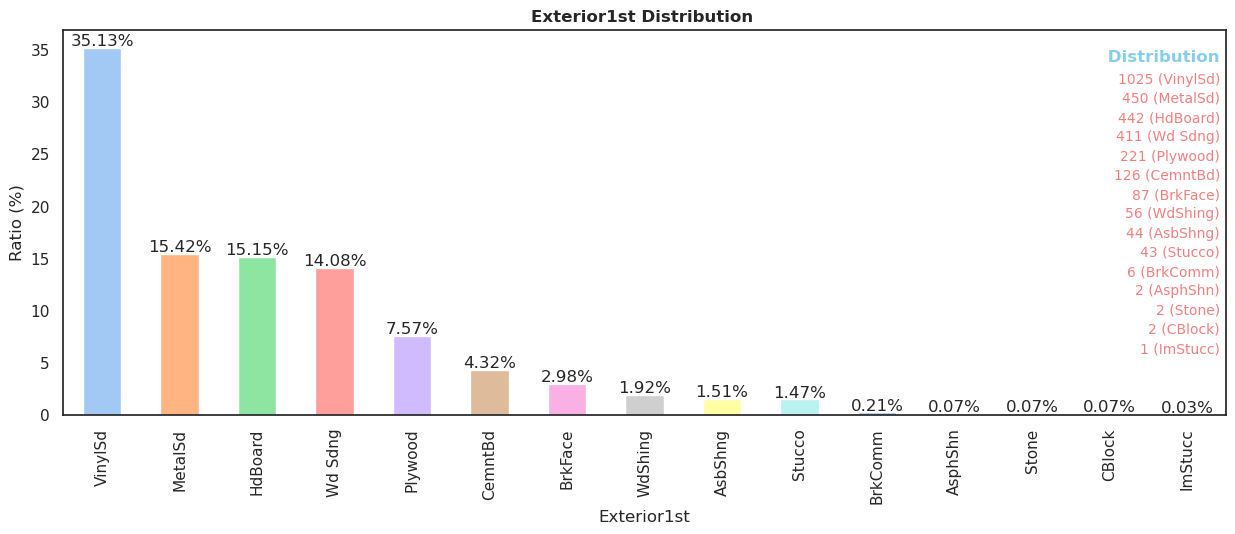

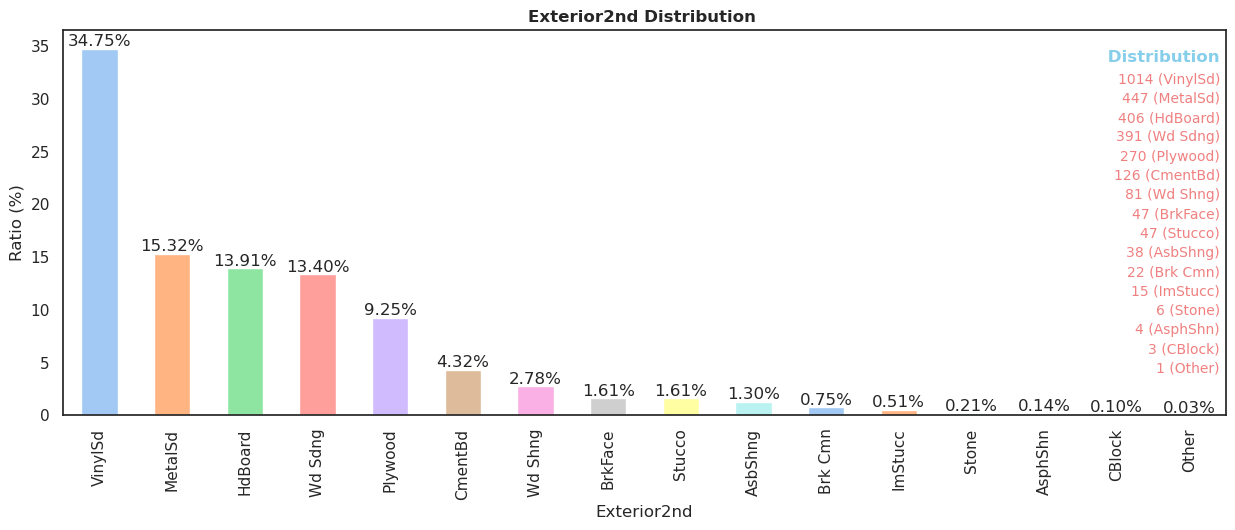

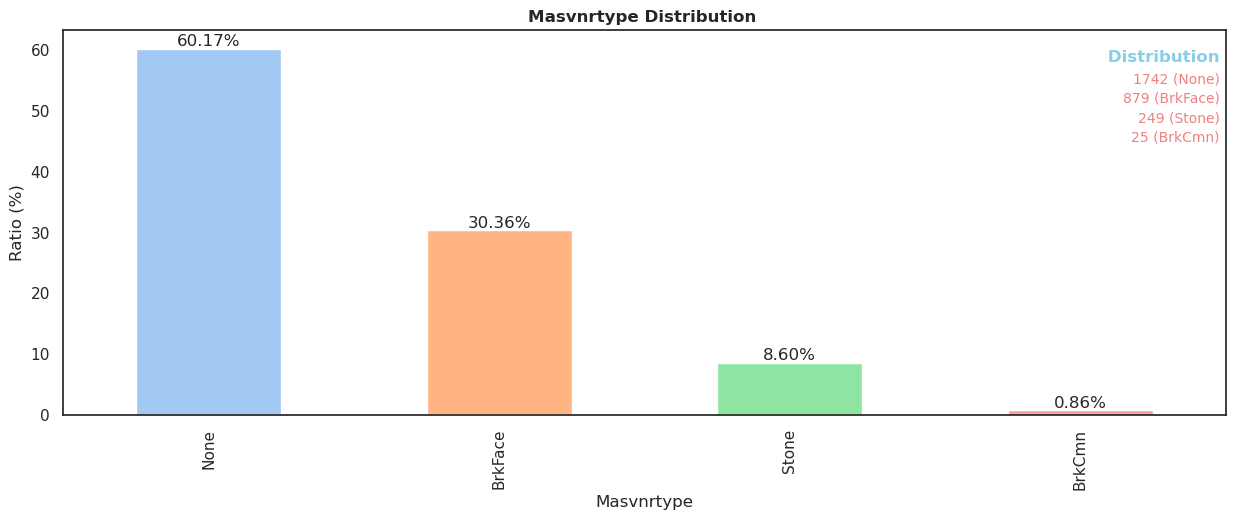

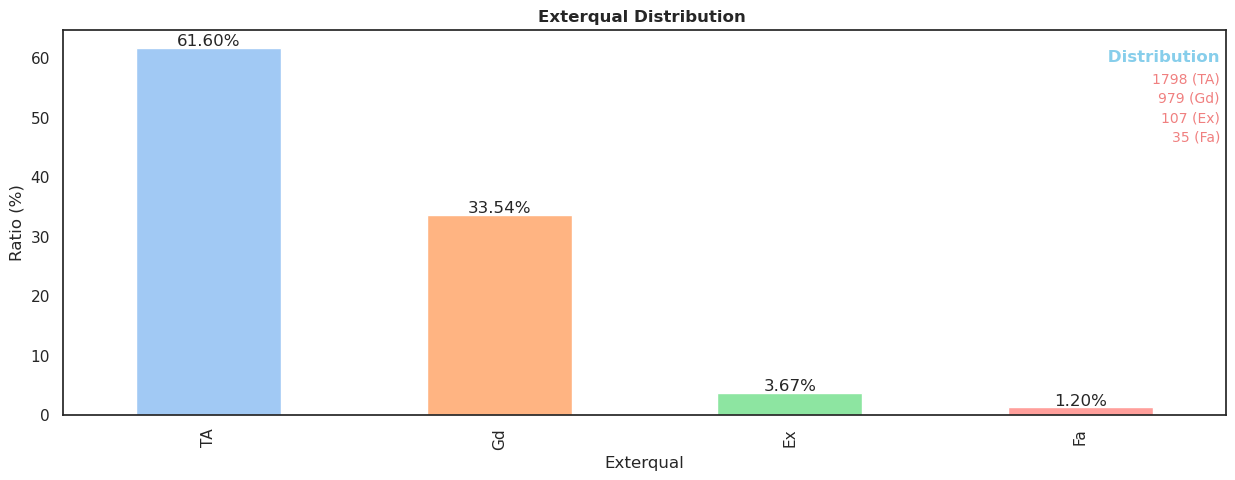

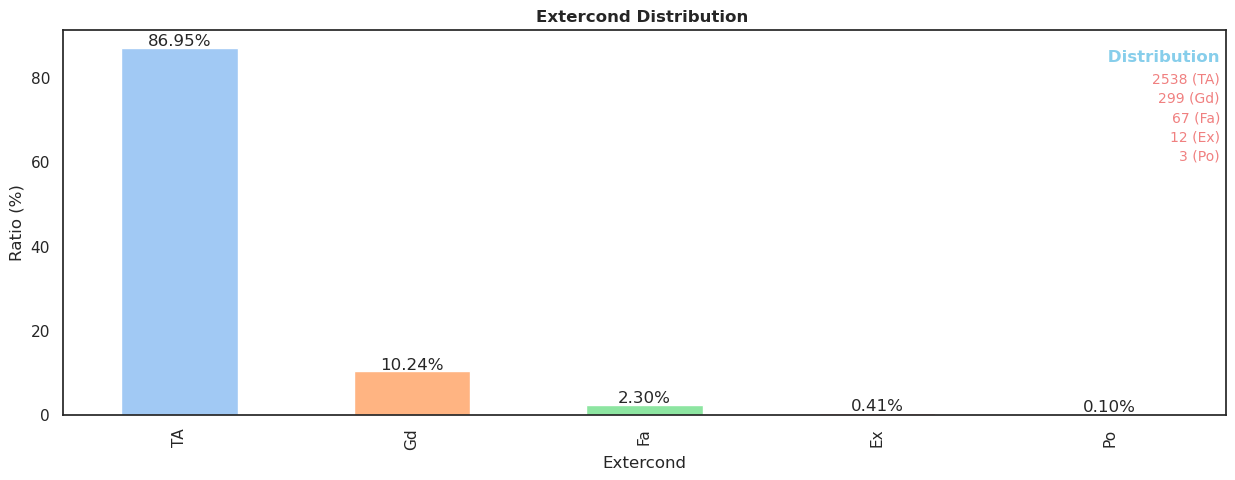

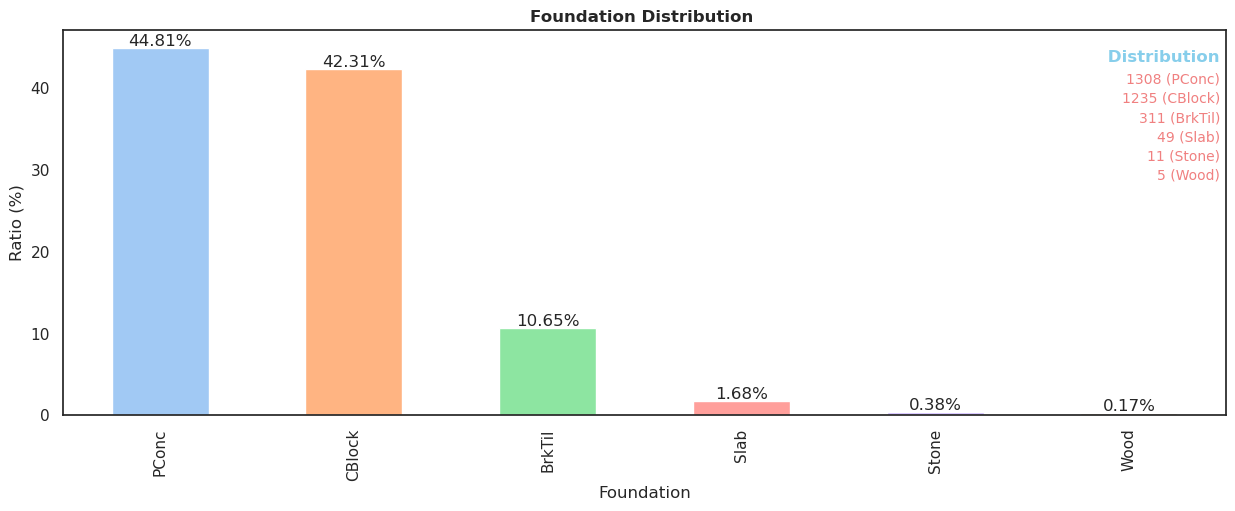

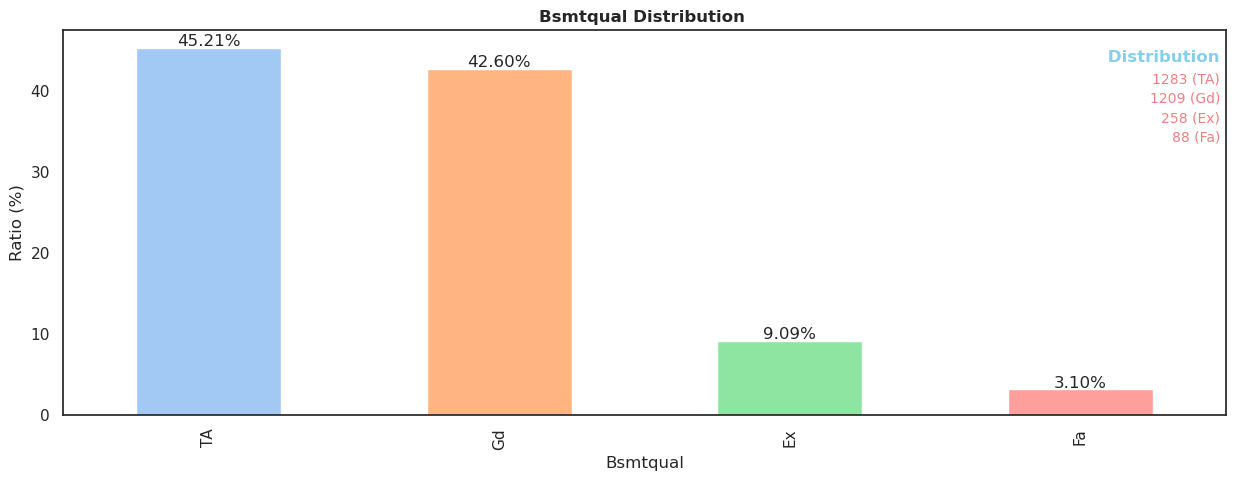

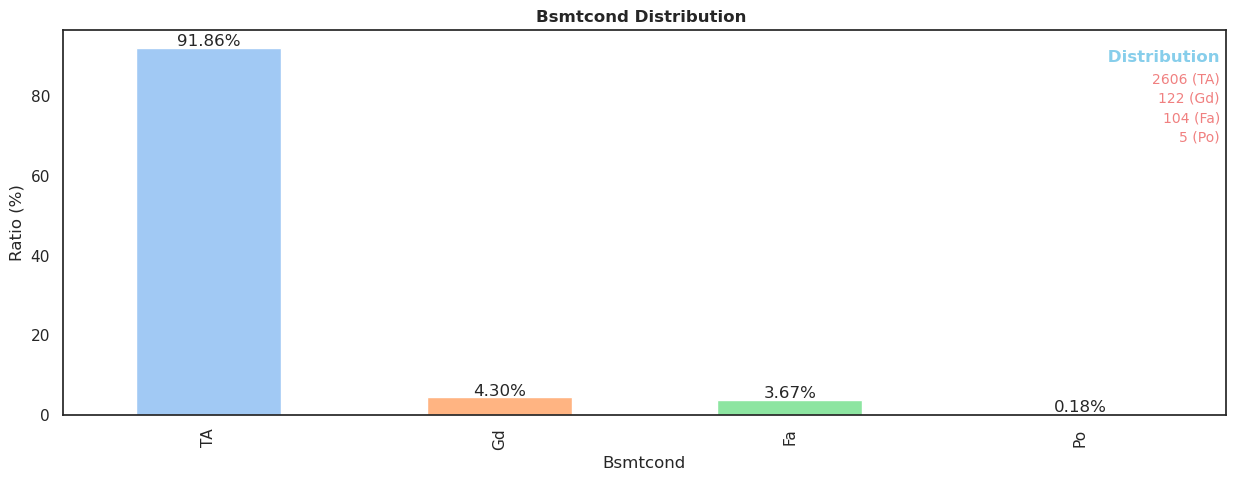

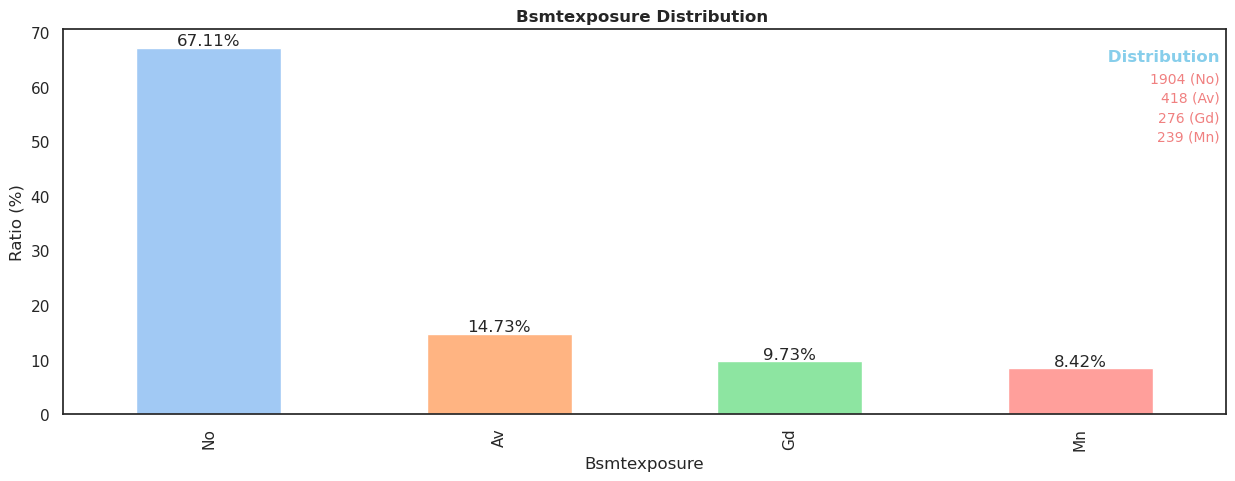

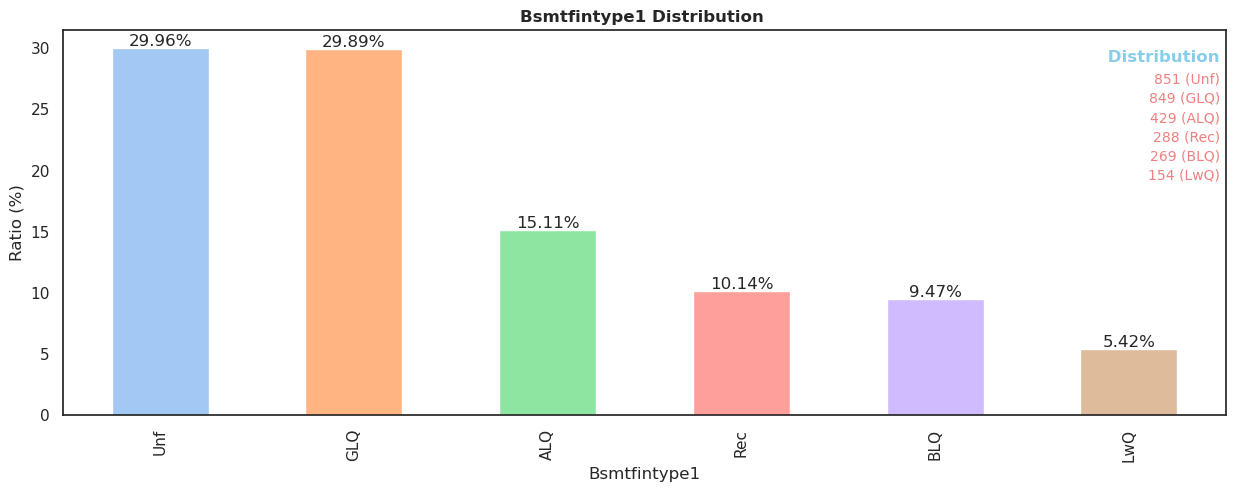

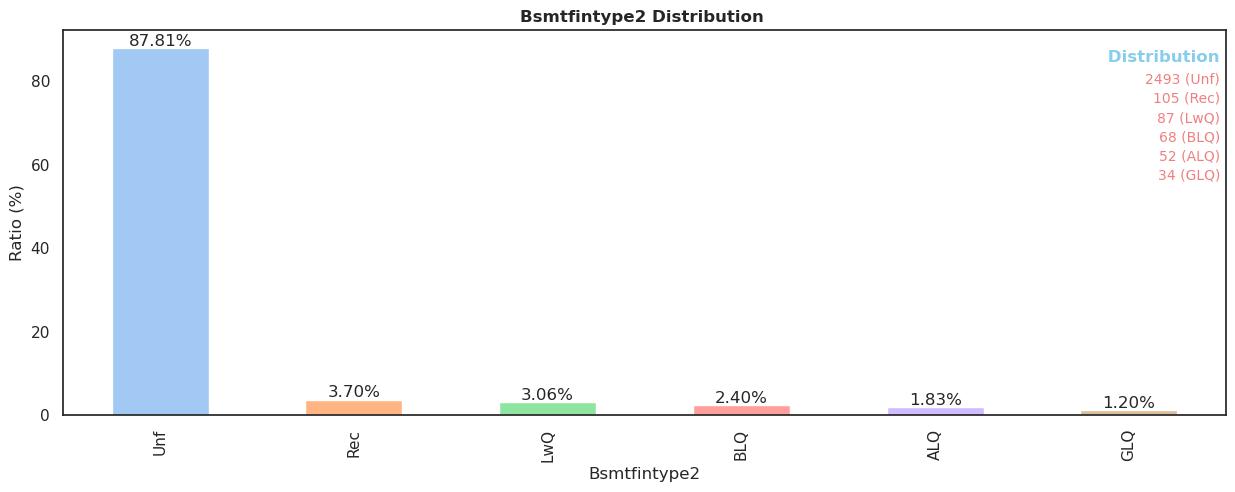

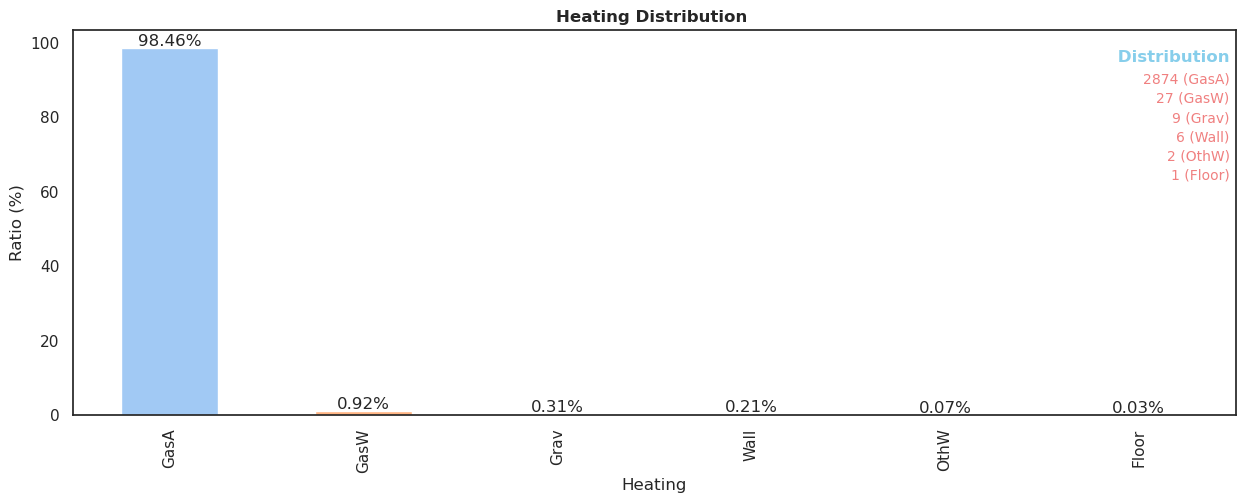

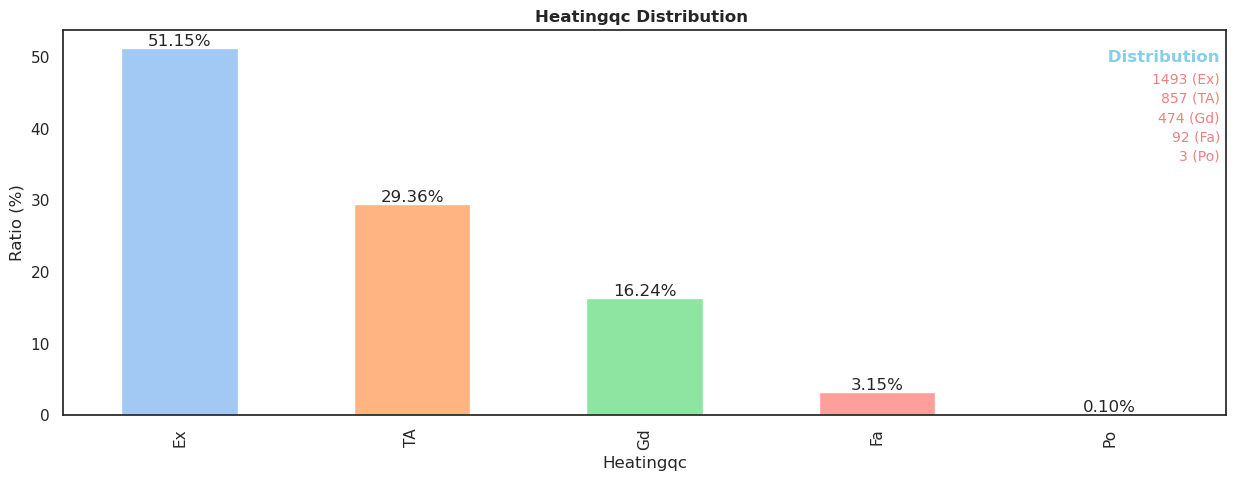

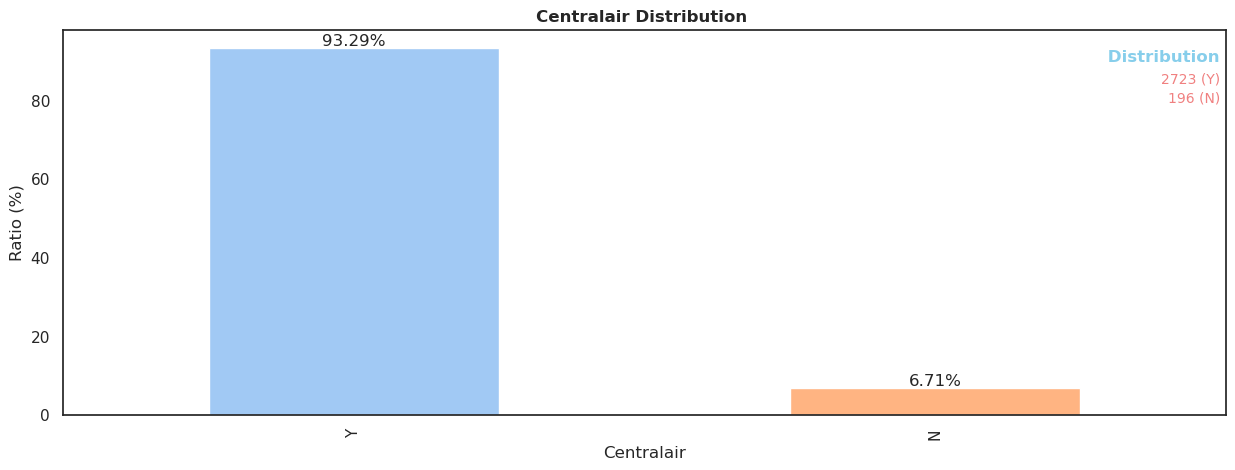

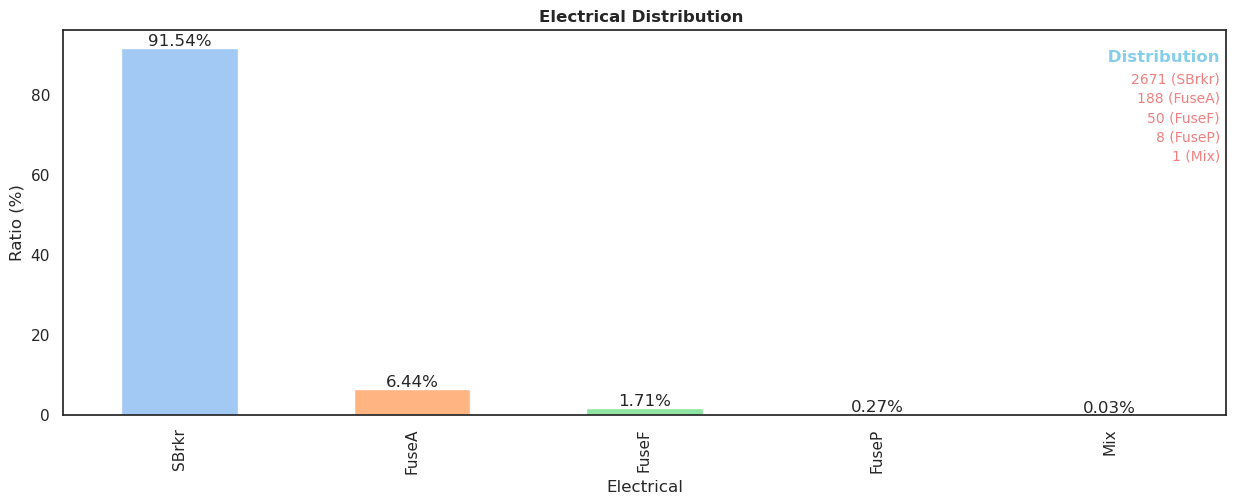

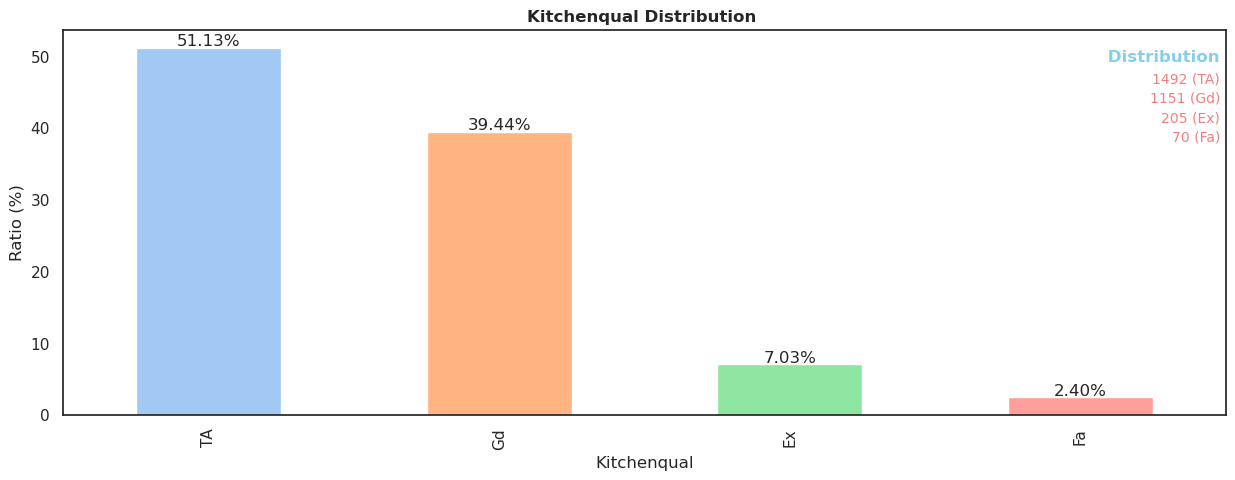

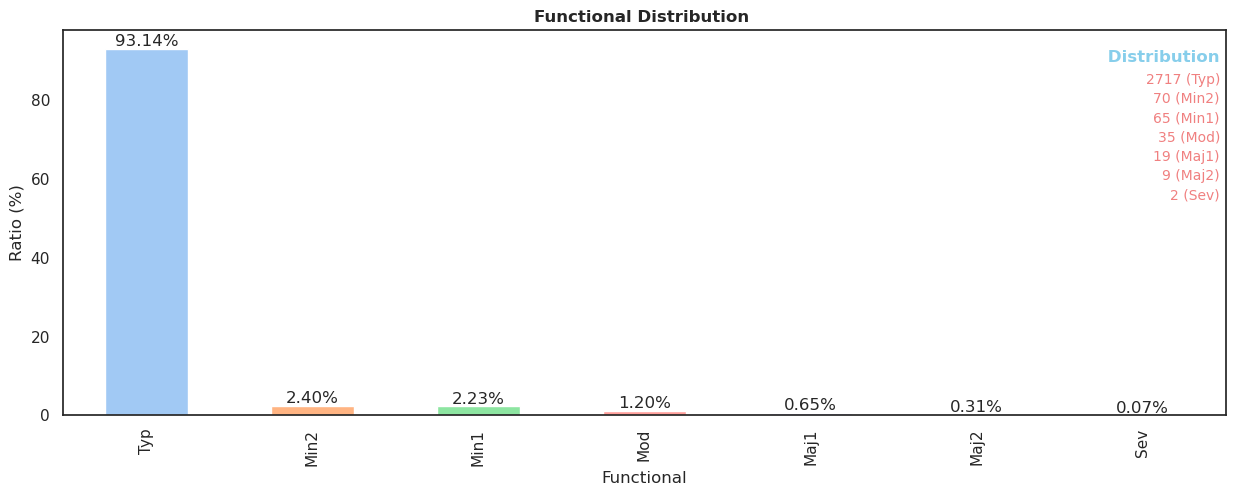

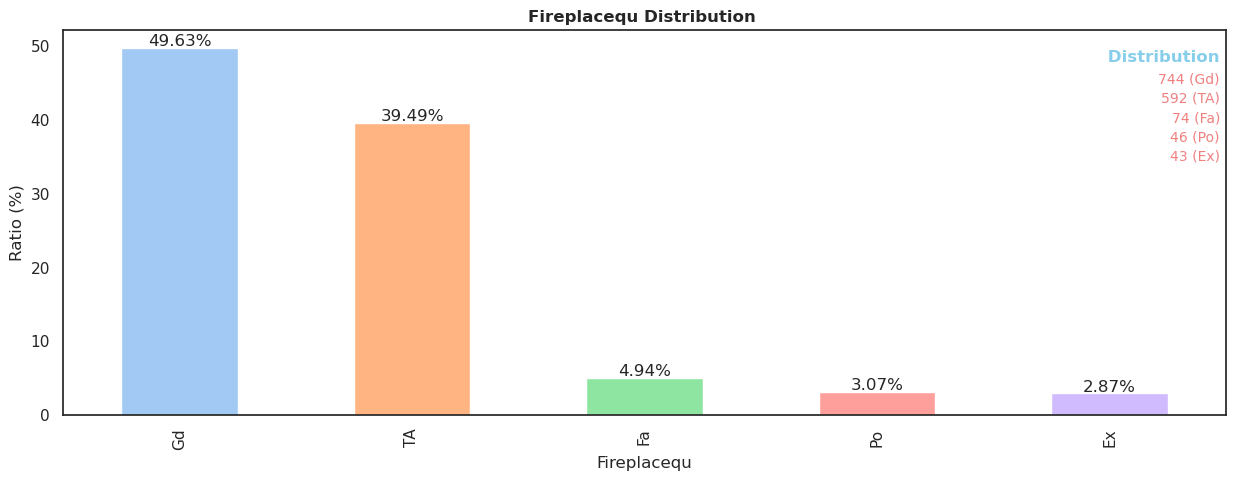

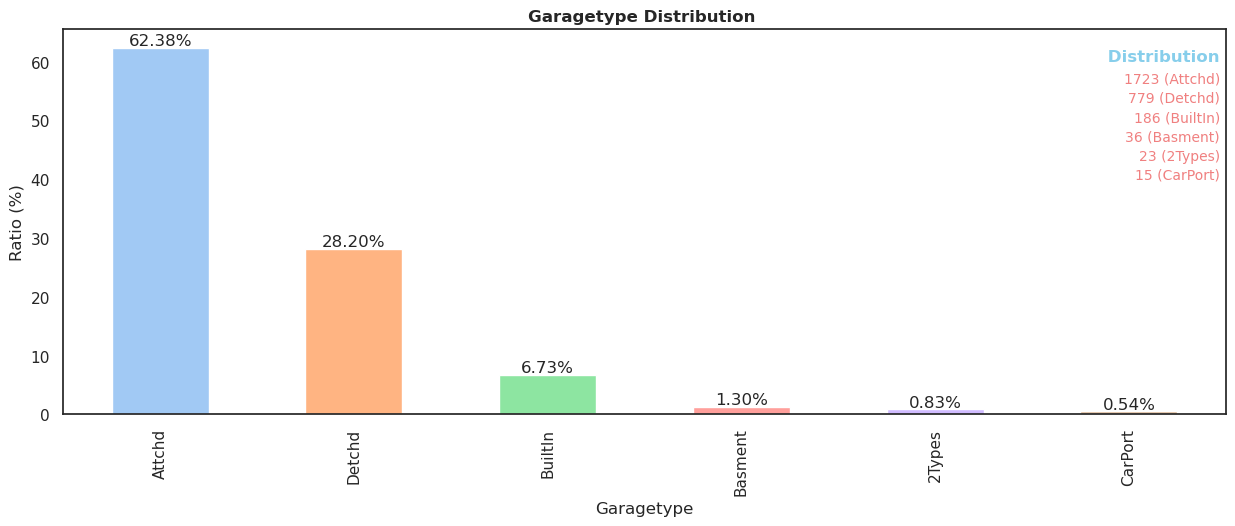

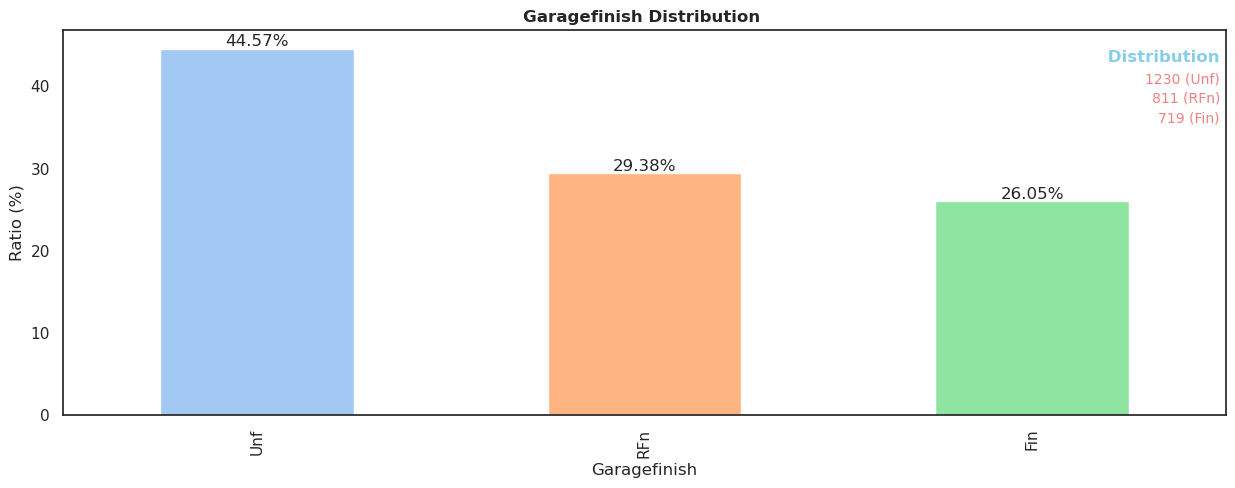

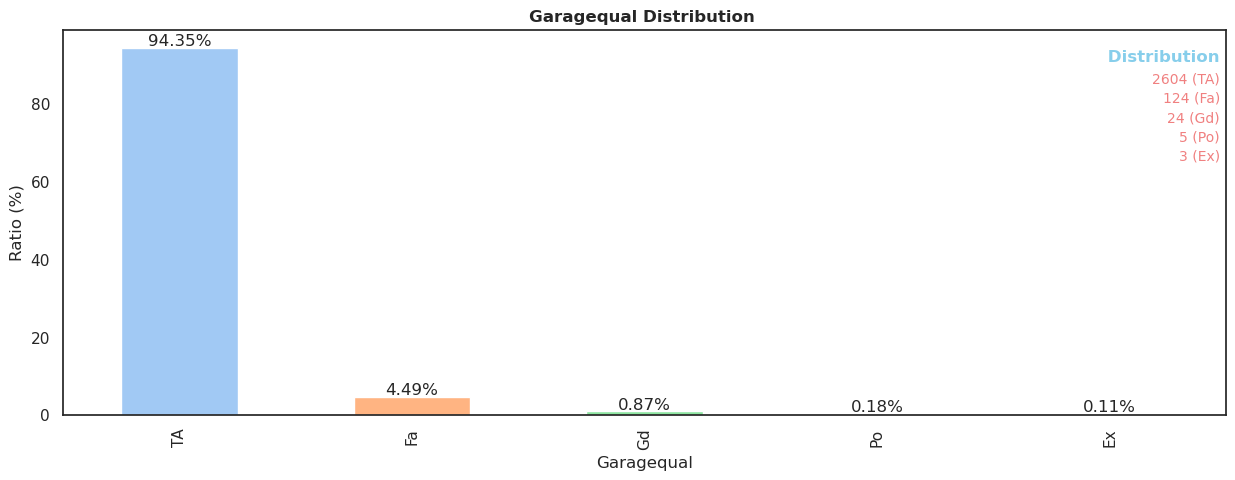

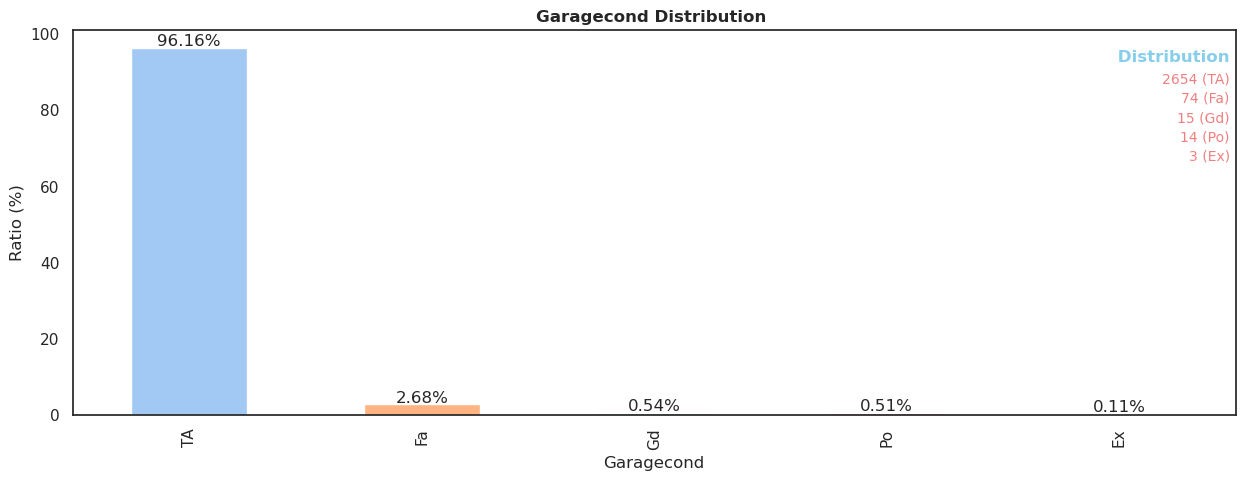

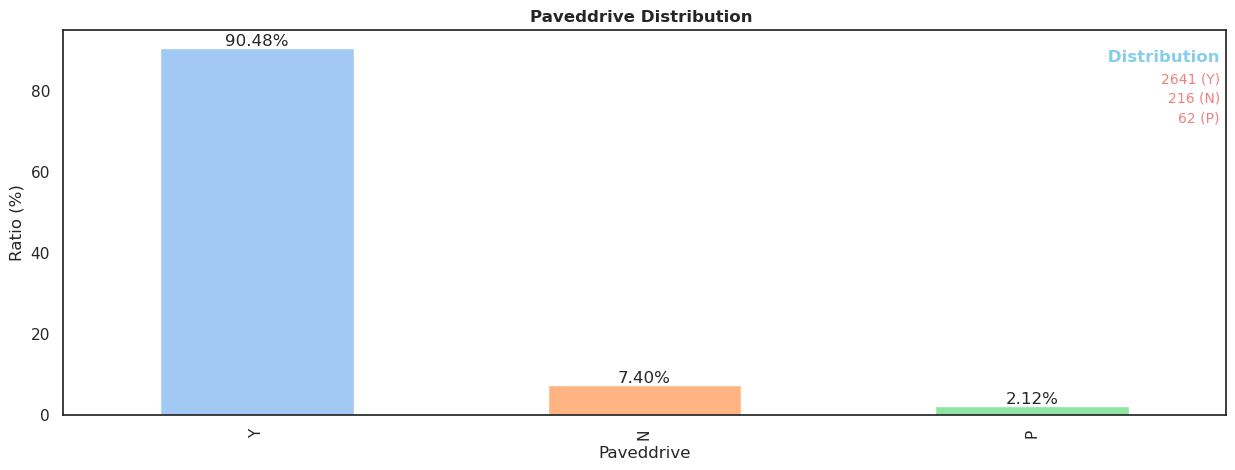

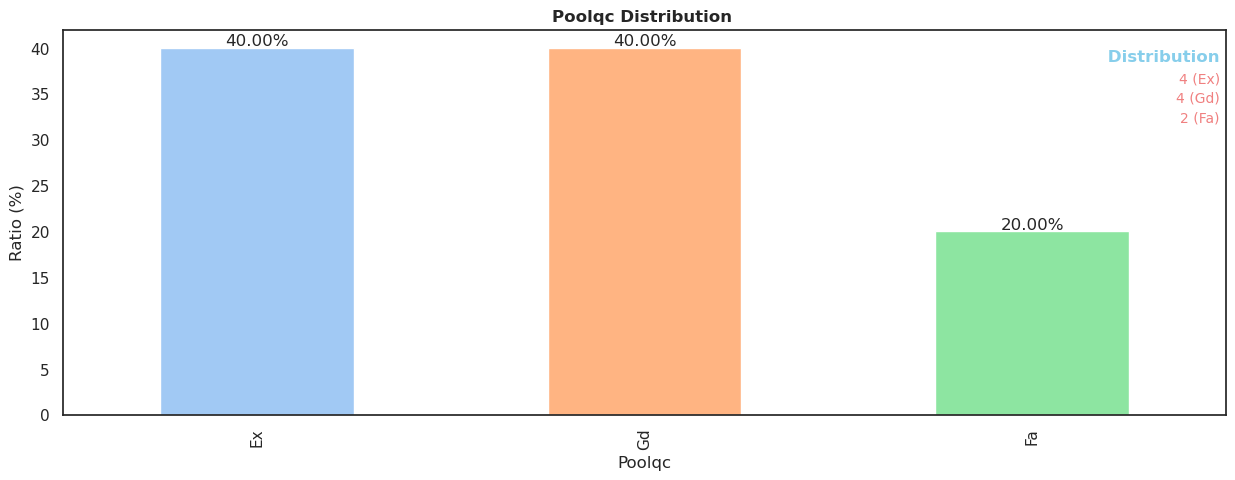

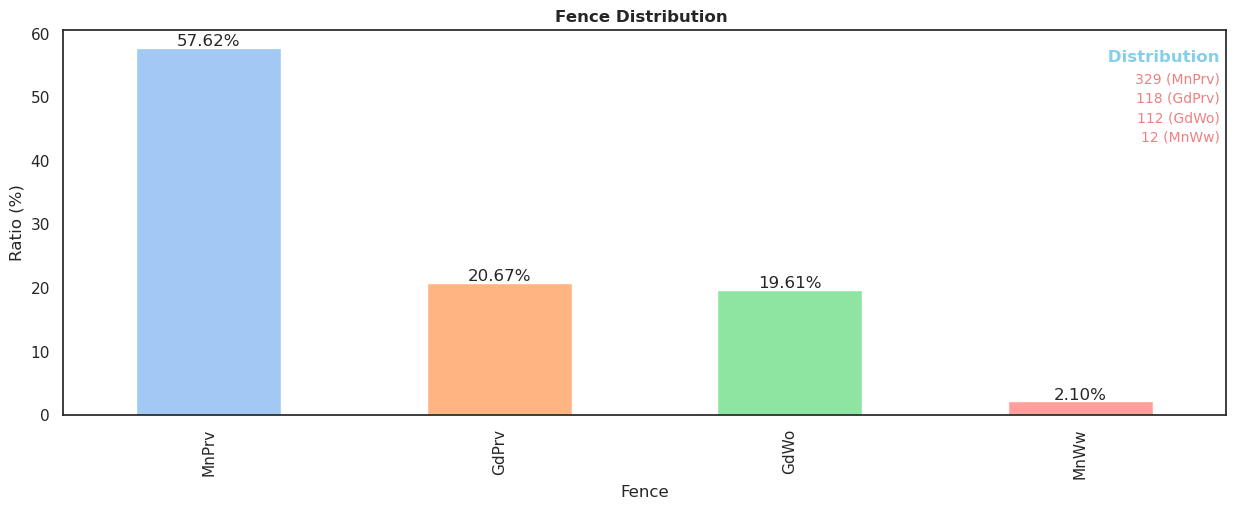

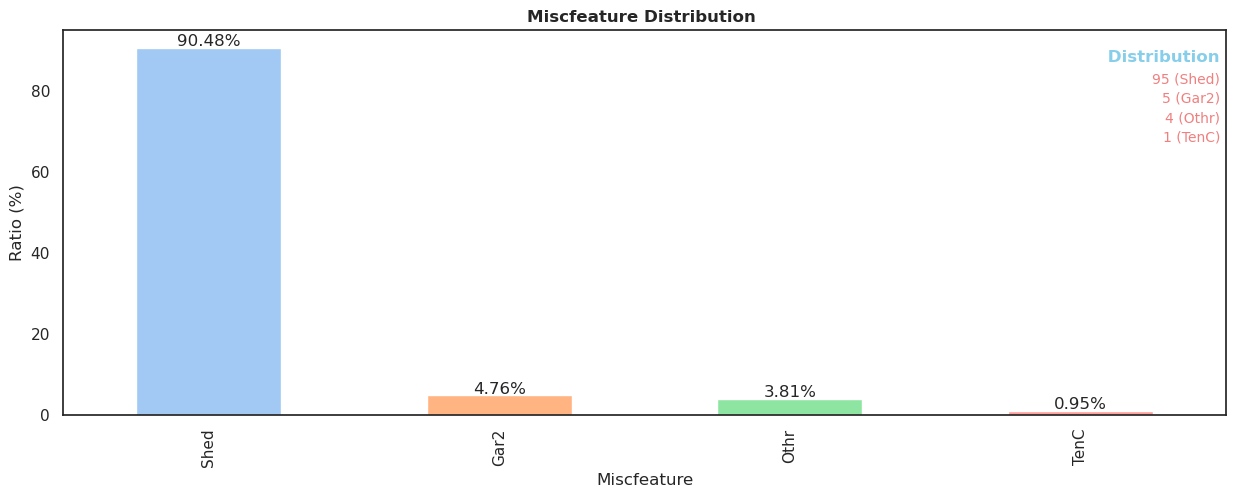

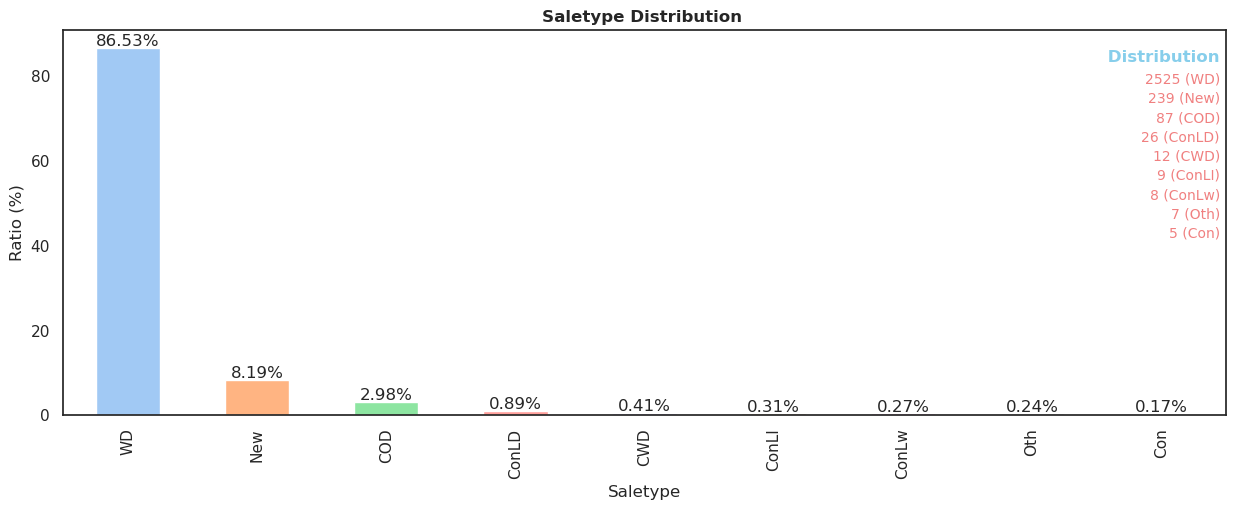

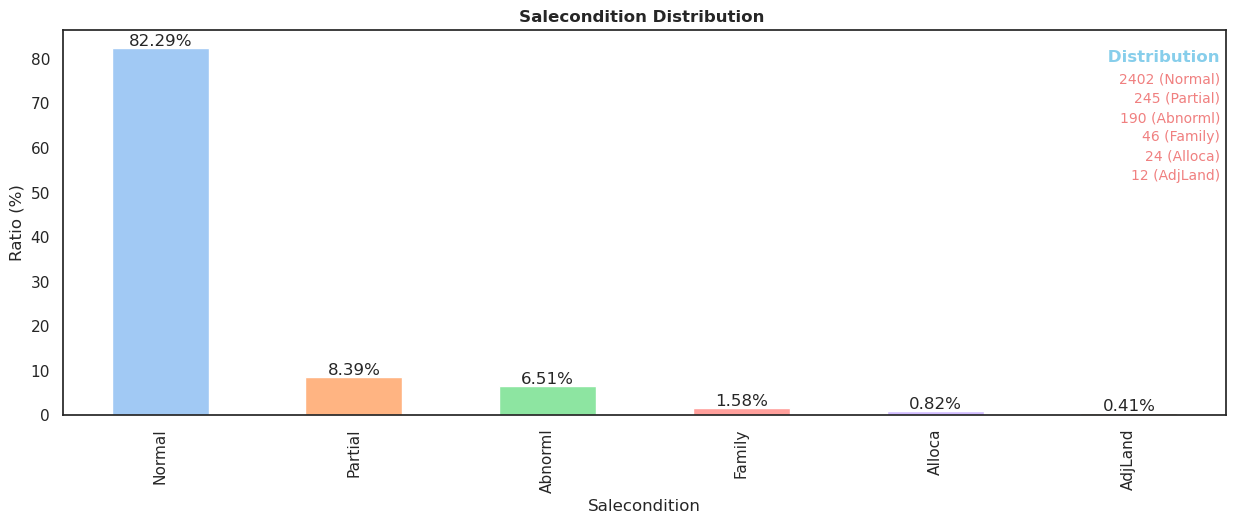

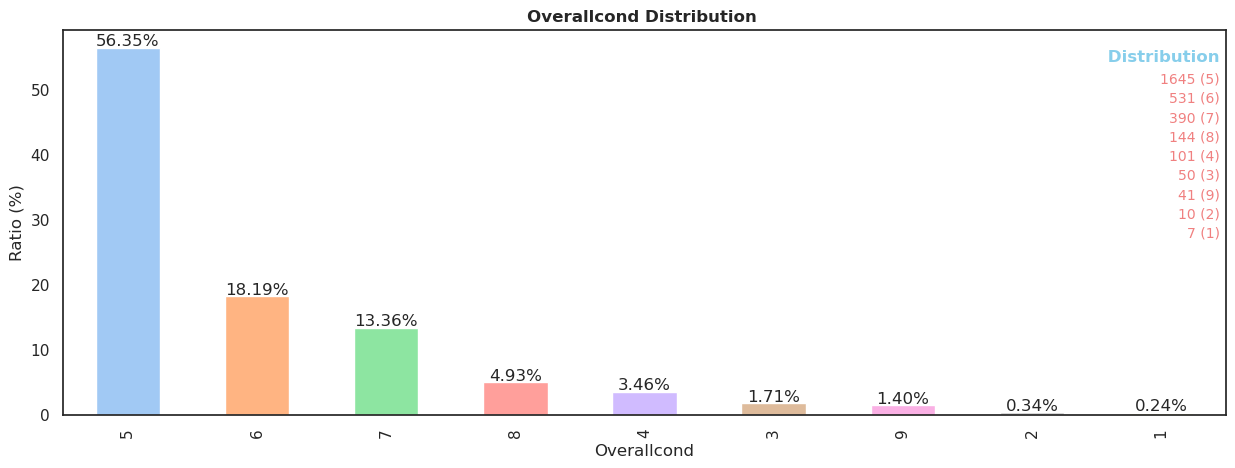

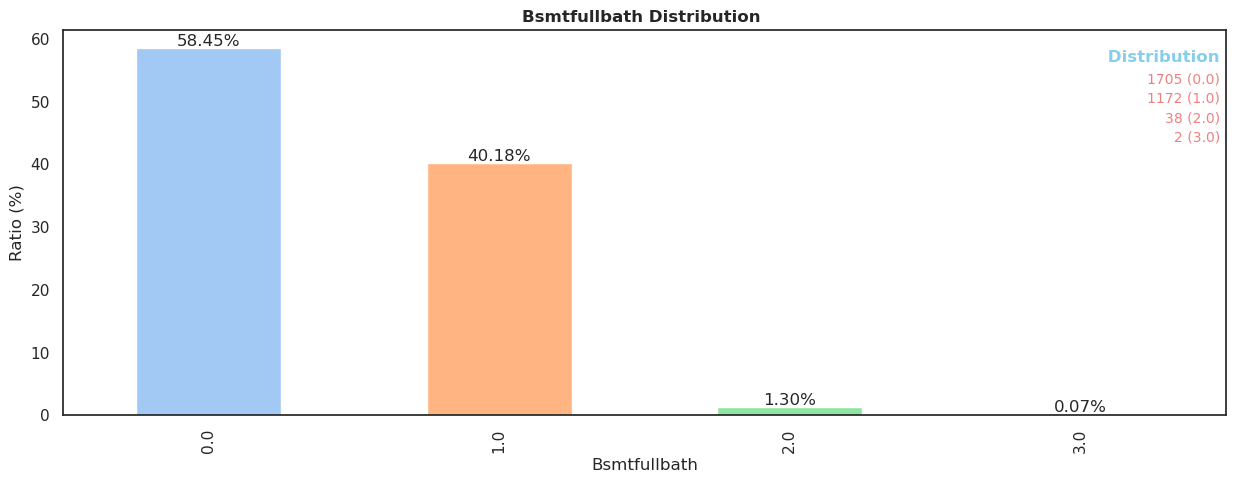

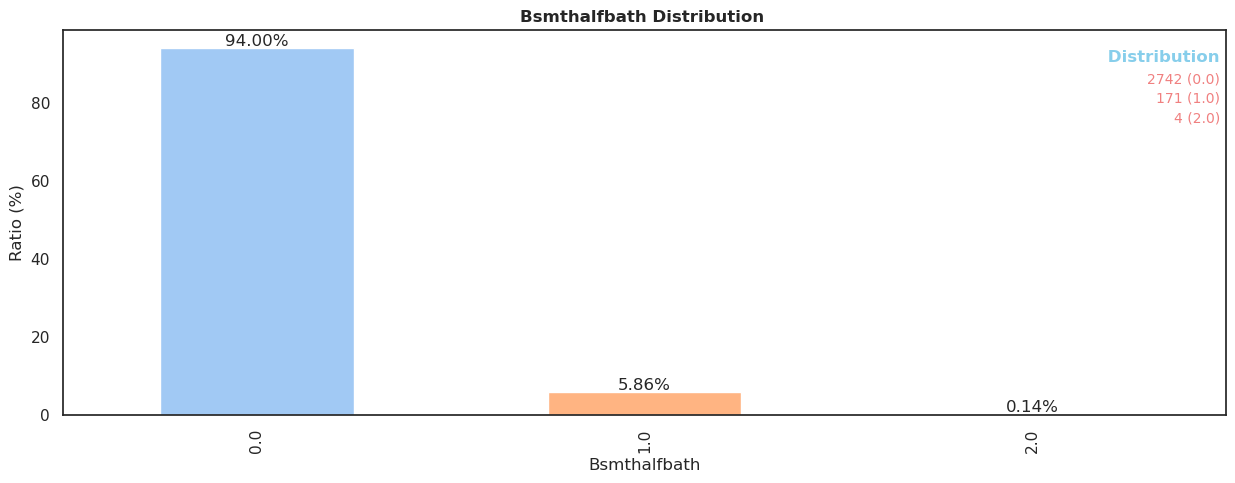

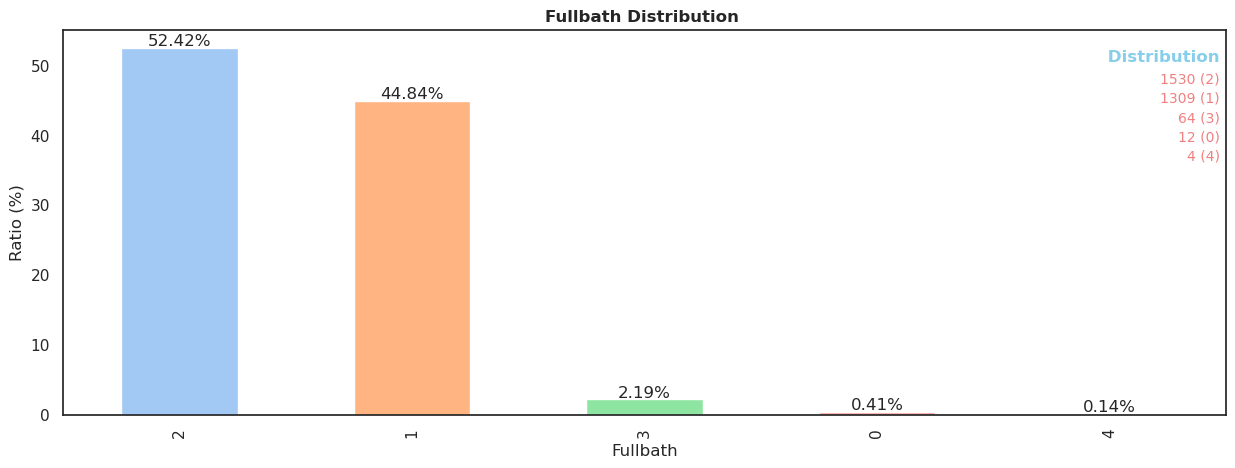

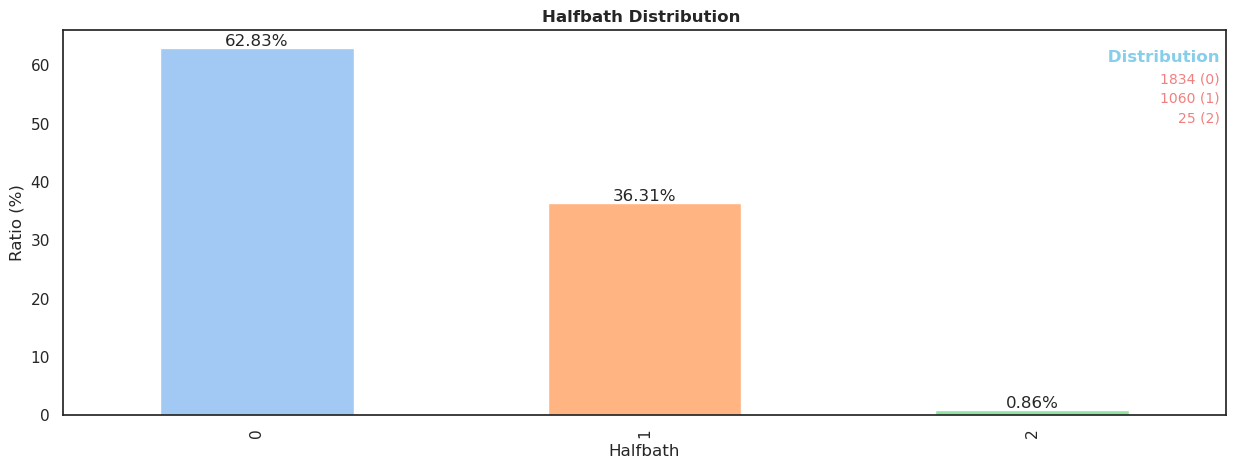

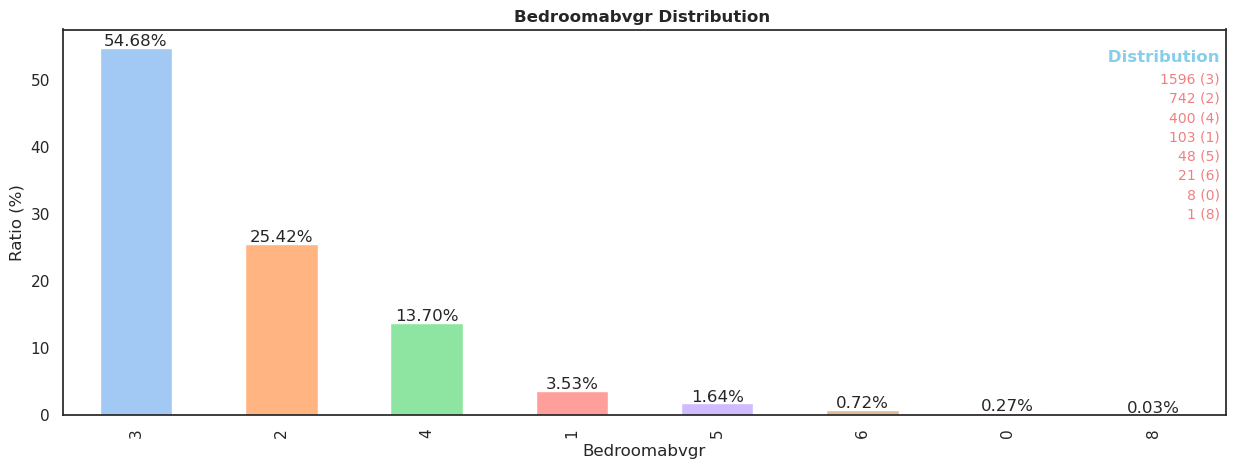

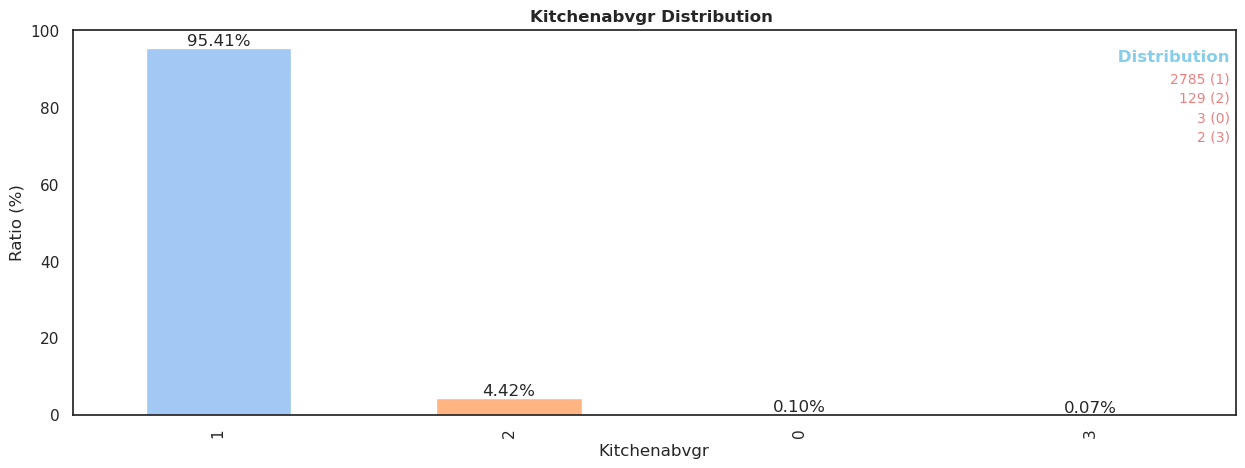

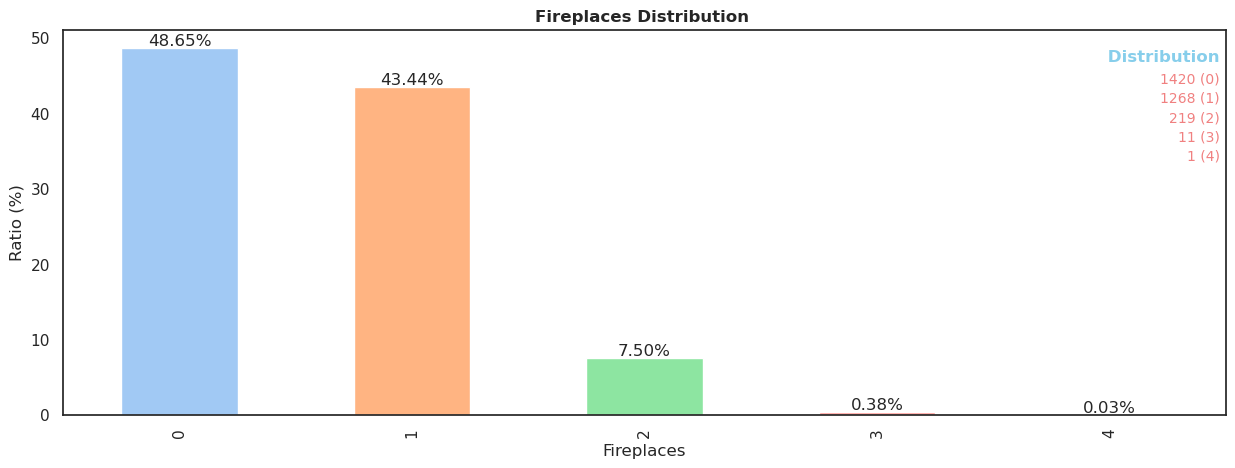

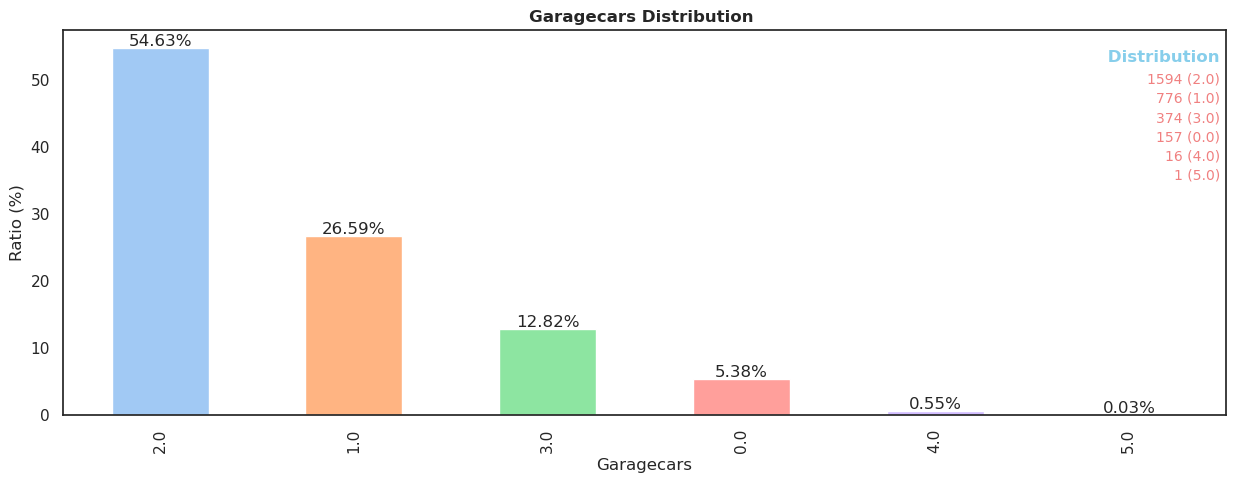

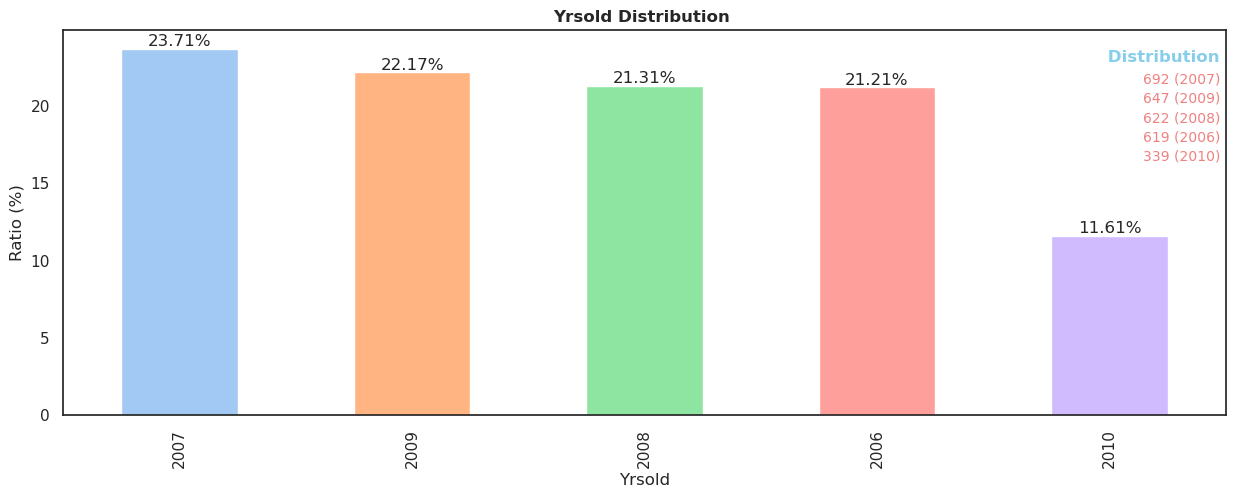

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
Cat_Cols = cat_cols
def catplot_all_cols():
    sns.set(style="white")
    colors = sns.color_palette("pastel")
    for col in Cat_Cols:
        fig, axs = plt.subplots(figsize=(15, 5))
        plt.subplot()
        total_counts = X[col].value_counts()
        value_counts = X[col].value_counts(normalize=True) * 100
        ax = value_counts.plot(kind='bar', color=colors)
        plt.xlabel(col.capitalize())
        plt.ylabel('Ratio (%)')
        plt.title(col.capitalize() + " Distribution ",fontweight='bold')
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        total = value_counts.sum()
        ax.text(0.995, 0.95, " Distribution", transform=ax.transAxes, ha='right', va='top', fontsize=12, fontweight='bold', color='skyblue')
    
        for i, value in enumerate(total_counts):
            ax.text(0.995, 0.89 - (i * 0.05), f'{total_counts.iloc[i]:.0f} ({total_counts.index[i]})', transform=ax.transAxes, ha='right', va='top', fontsize=10, color='lightcoral')
        ax.grid(False)
        plt.show()
catplot_all_cols()


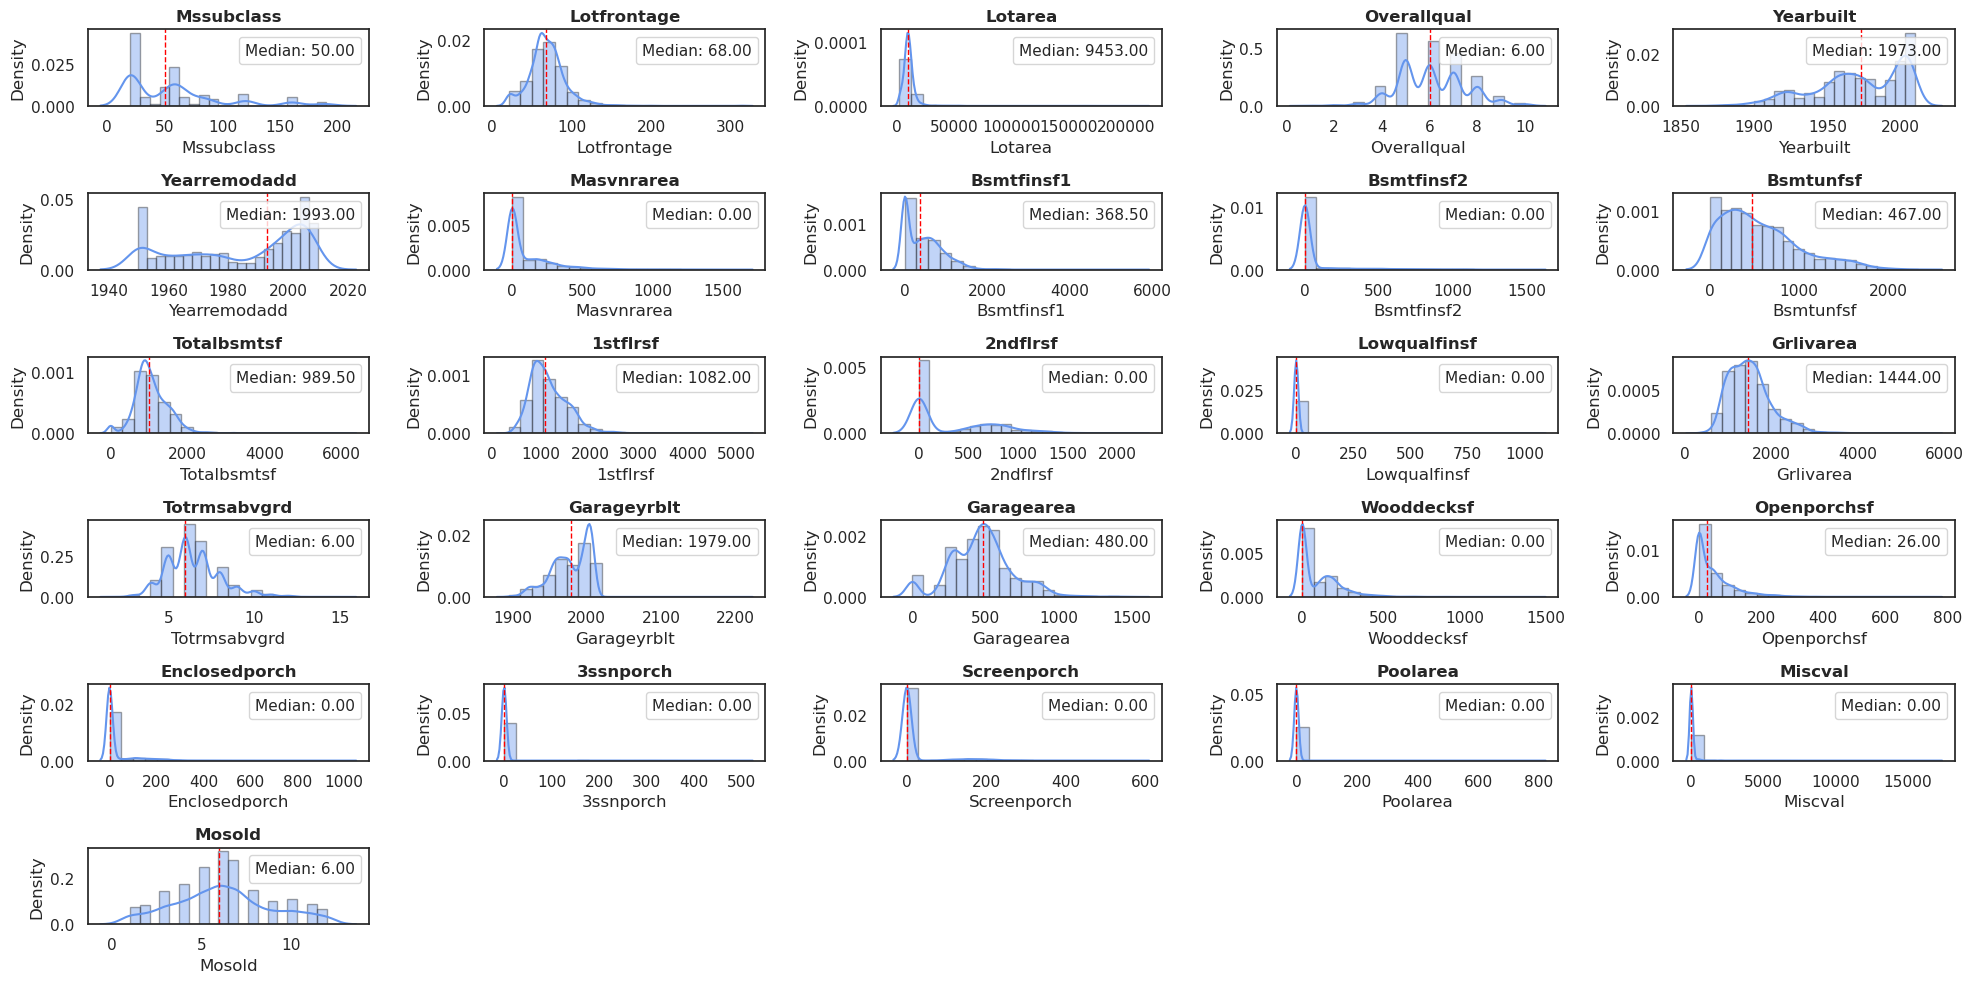

In [8]:
num_cols = num_cols
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(num_cols):
    sns.distplot(X[col], ax=axs[i], color="cornflowerblue", hist_kws=dict(linewidth=1, edgecolor="k"), bins=20)
    axs[i].set_title(col.capitalize(), fontweight='bold')
    axs[i].set_xlabel(col.capitalize())
    median_value = X[col].median()
    
    axs[i].axvline(x=median_value, color='red', linestyle='--', linewidth=1)
    axs[i].legend([f"Median: {median_value:.2f}"], loc='upper right', handlelength=0, handletextpad=0)
[fig.delaxes(axs) for axs in axs.flatten() if not axs.has_data()]
fig.tight_layout()
plt.show()


In [9]:
X["Bin1"]=pd.qcut(X['GrLivArea'],5,["A","B,","C","D","E"])
X["Bin2"]=pd.qcut(X['YearBuilt'],5,["A","B,","C","D","E"])
X["Bin3"]=pd.qcut(X['GarageArea'],5,["A","B,","C","D","E"])
X["Bin4"]=pd.qcut(X['TotalBsmtSF'],5,["A","B,","C","D","E"])
X["Bin5"]=pd.qcut(X['1stFlrSF'],5,["A","B,","C","D","E"])

In [10]:
for col in num_cols:
    print(col, check_outlier(X, col))

MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


In [11]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
  replace_with_thresholds(X, col)

In [12]:
for col in num_cols:
    print(col, check_outlier(X, col))

MSSubClass False
LotFrontage False
LotArea False
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
MoSold False


<Axes: >

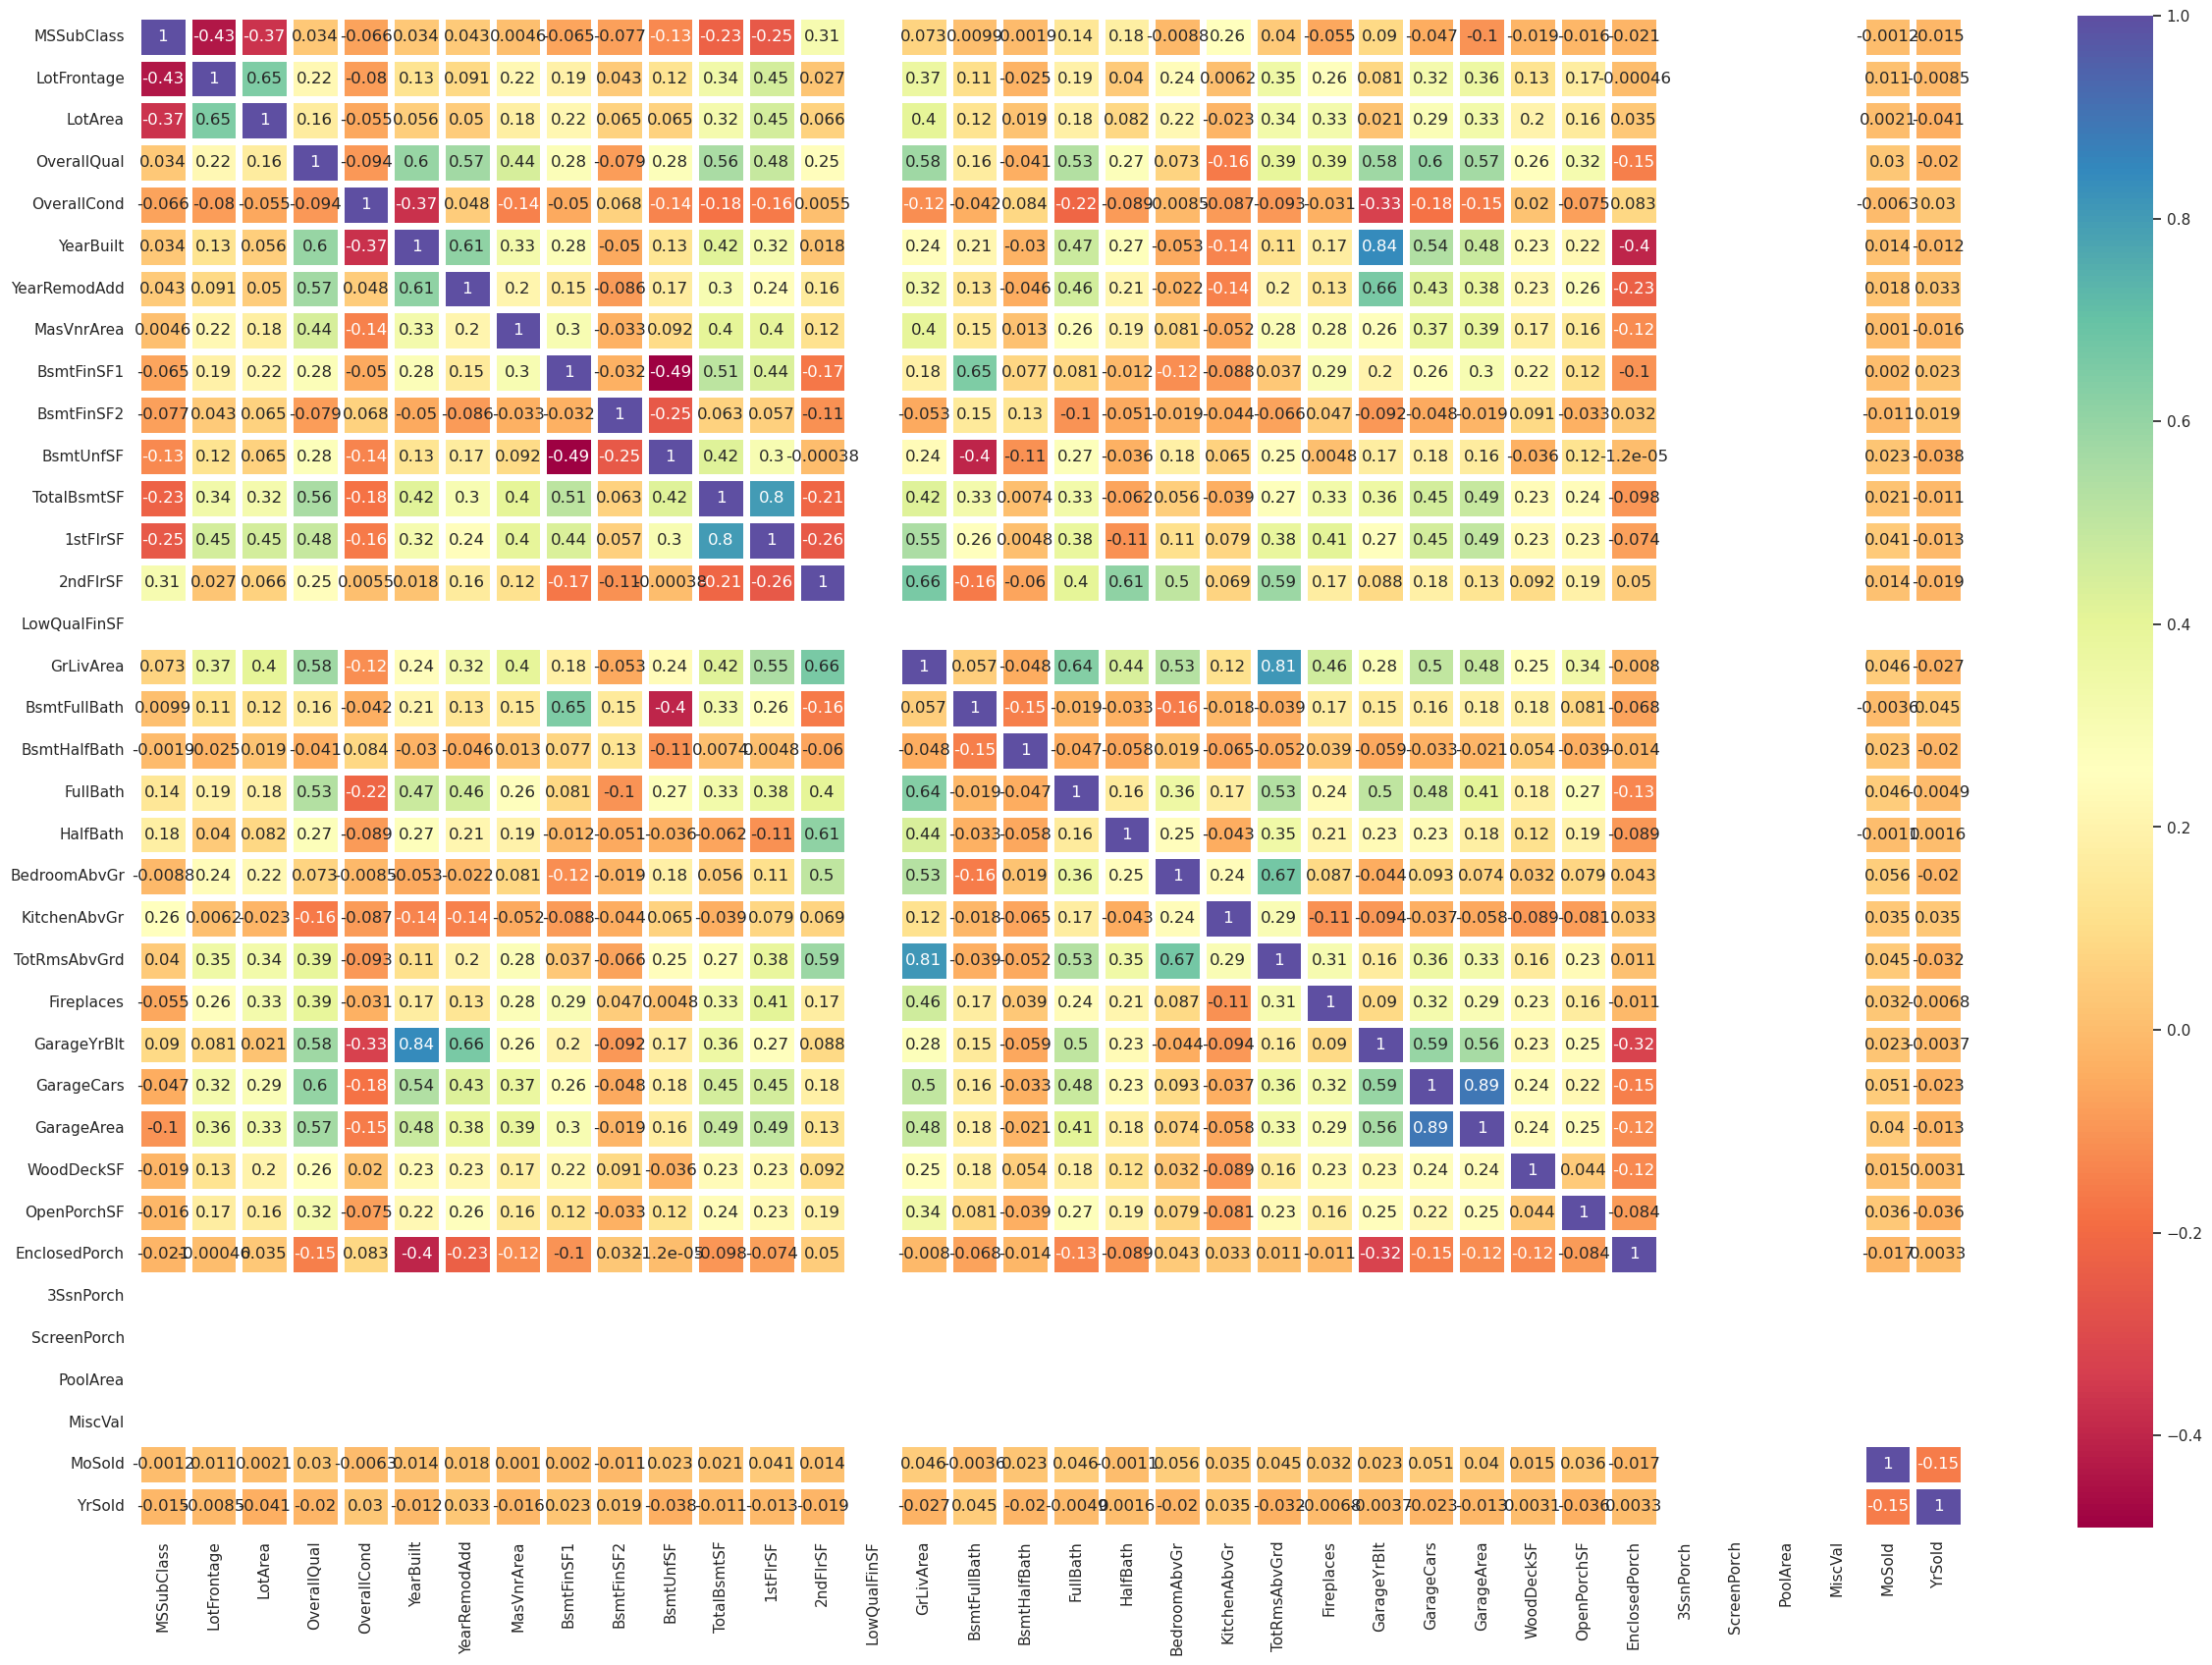

In [13]:
plt.figure(figsize=(30,20))
sns.heatmap(X.corr(),cmap="Spectral",annot=True,linewidth=5.)


In [14]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.9):
    corr = dataframe.corr().abs()
    upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle.columns if any(upper_triangle[col] > corr_th)]
    return drop_list

In [15]:
def uhigh_correlated_cols(dataframe, plot=False, corr_th=0.9):
    corr = dataframe.corr().abs()
    corr = dataframe.corr().abs()
    lower_triangle = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(np.bool))
    drop_list = [col for col in lower_triangle.columns if any(lower_triangle[col] > corr_th)]
    return drop_list

In [16]:
drop_list = list(set(high_correlated_cols(X) + uhigh_correlated_cols(X)))
drop_list


[]

In [17]:
numeric_train = train.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

SalePrice
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
LowQualFinSF   -0.025606
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
EnclosedPorch  -0.128578
KitchenAbvGr   -0.135907

In [18]:
X.drop(["PoolArea",
"MoSold",
"3SsnPorch",
"BsmtFinSF2",
"BsmtHalfBath",
"MiscVal",
"LowQualFinSF",
"YrSold",
"OverallCond",
"MSSubClass"],inplace=True,axis=1)


<Axes: >

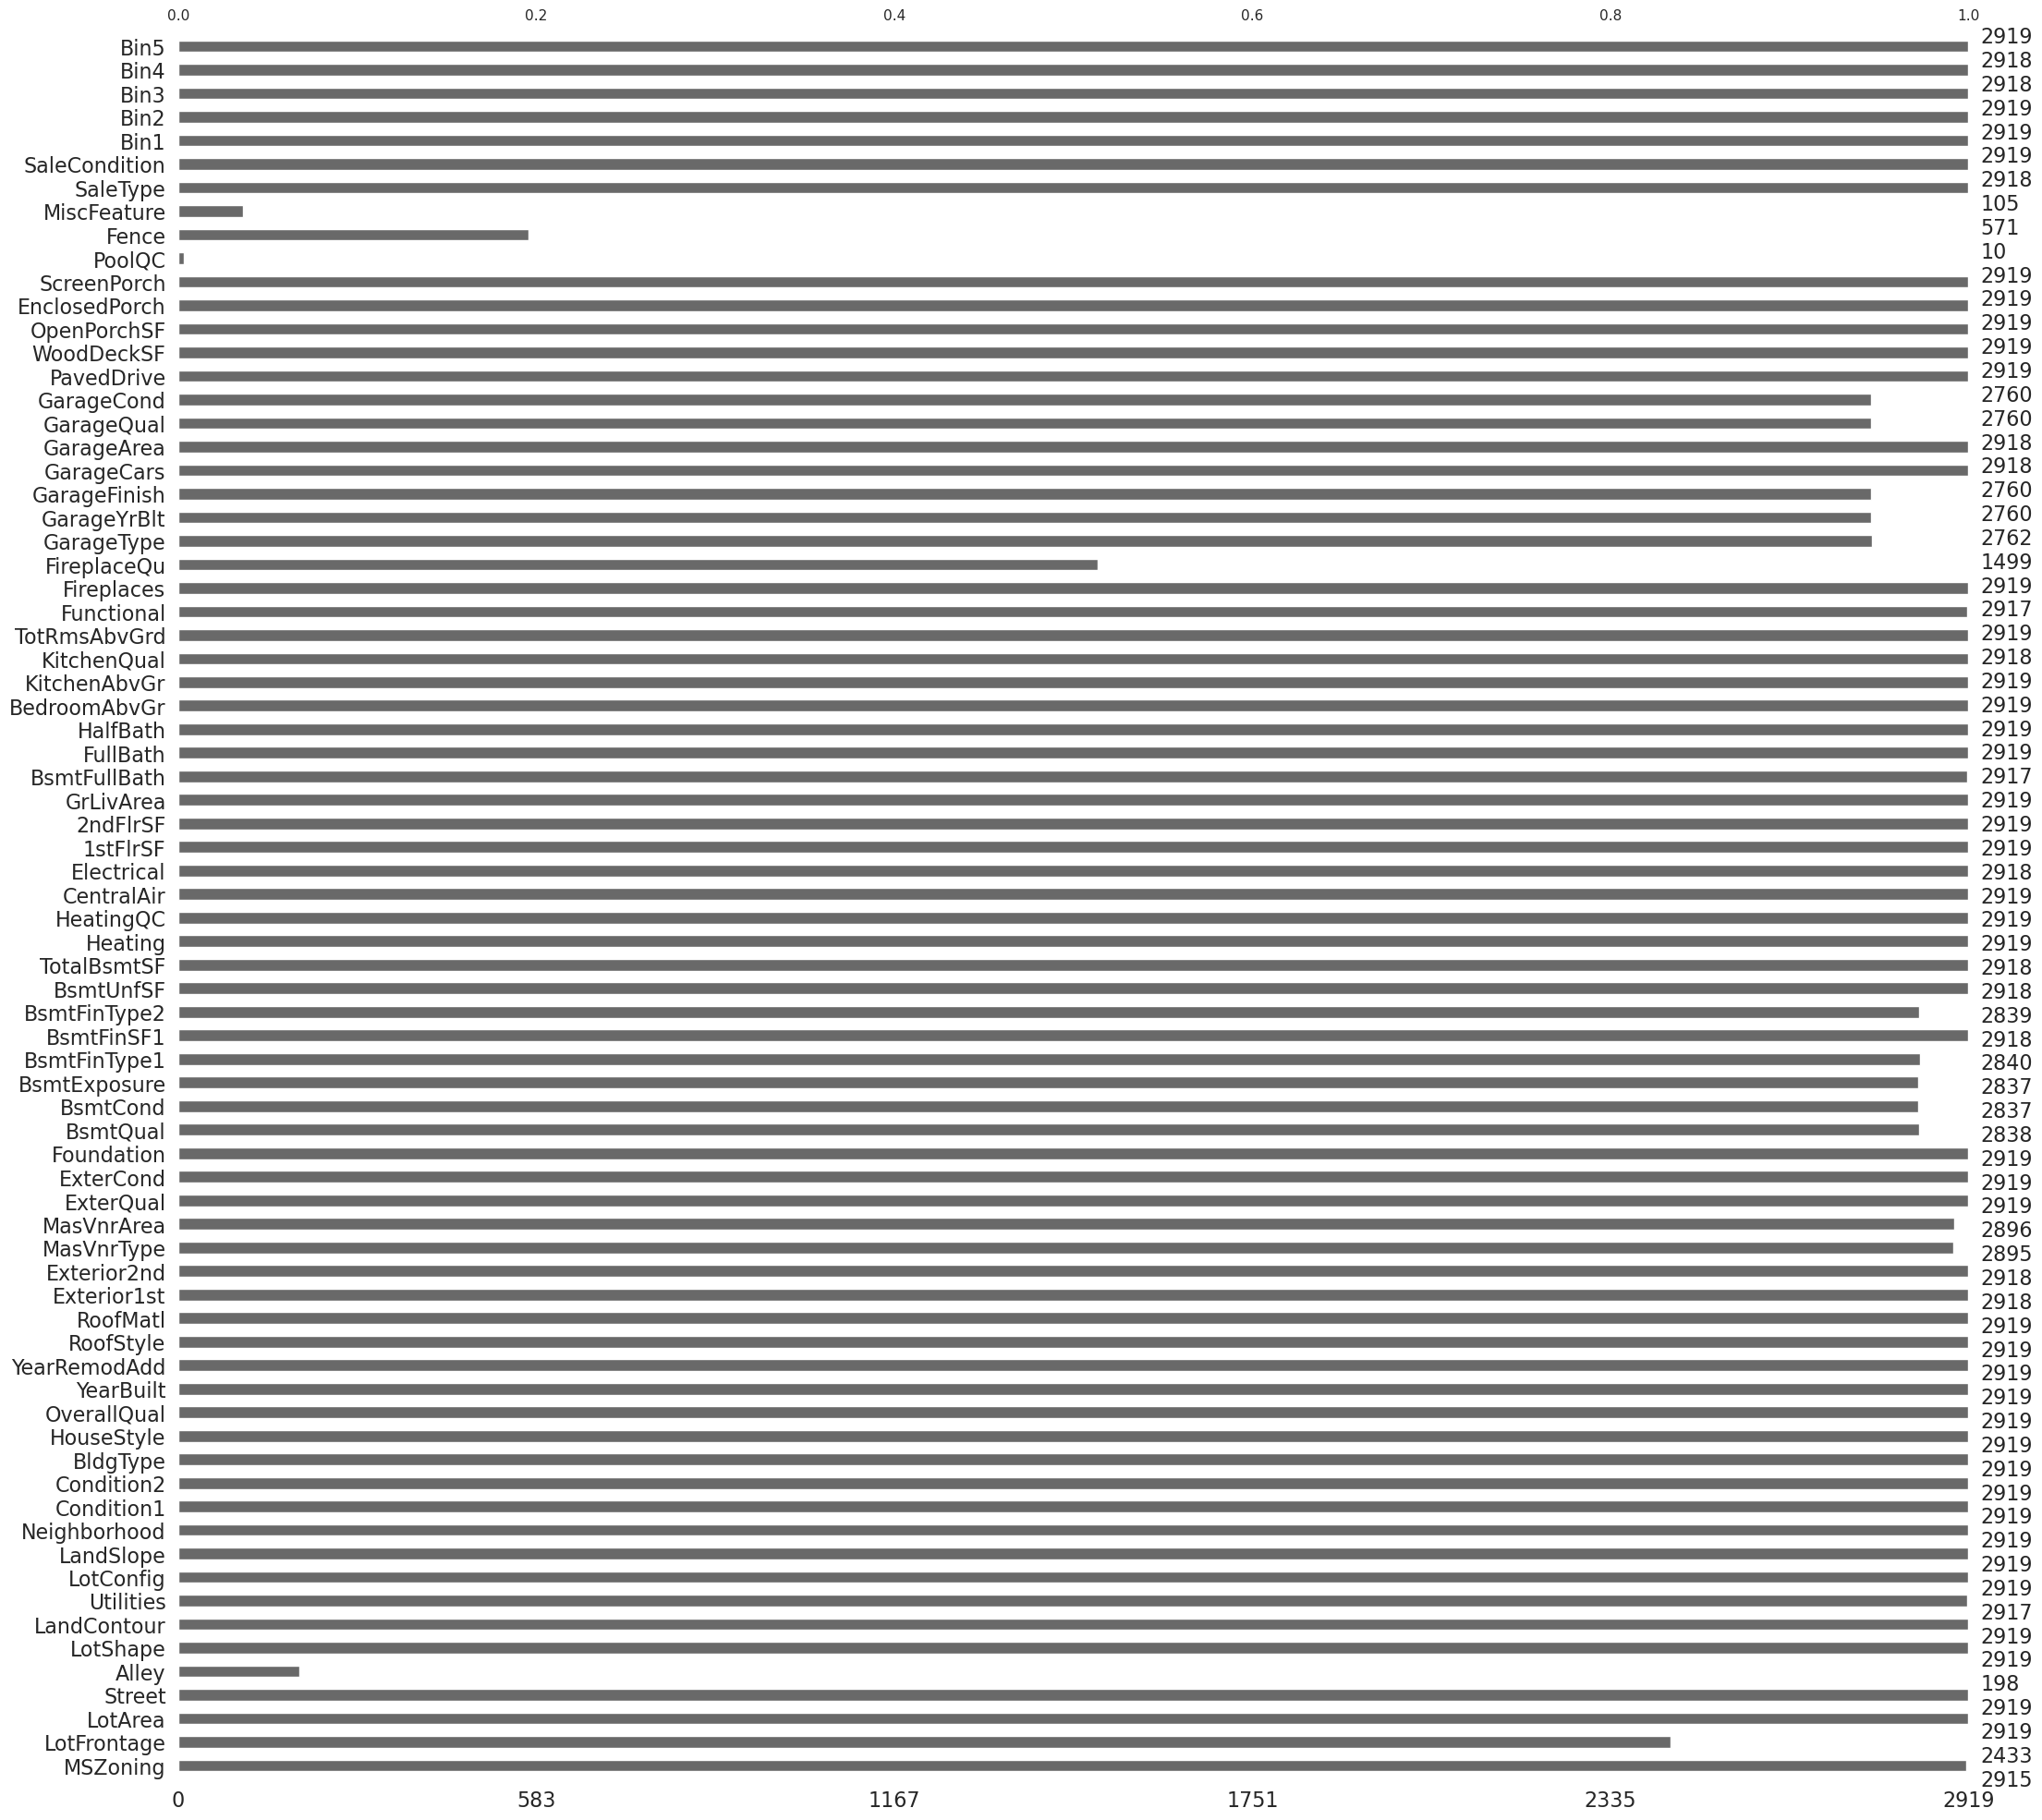

In [19]:
import missingno
missingno.bar(X)

In [20]:
X.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1, inplace=True)

In [21]:
X=X.apply(lambda x: x.fillna(x.mode()[0]) if ((x.dtype == "O" or x.dtype=="category") and len(x.unique()) <= 10) else x, axis=0)

In [22]:
X=X.apply(lambda x: x.fillna(x.mean()) if (x.dtype == "int" or x.dtype=="float") else x, axis=0)

<Axes: >

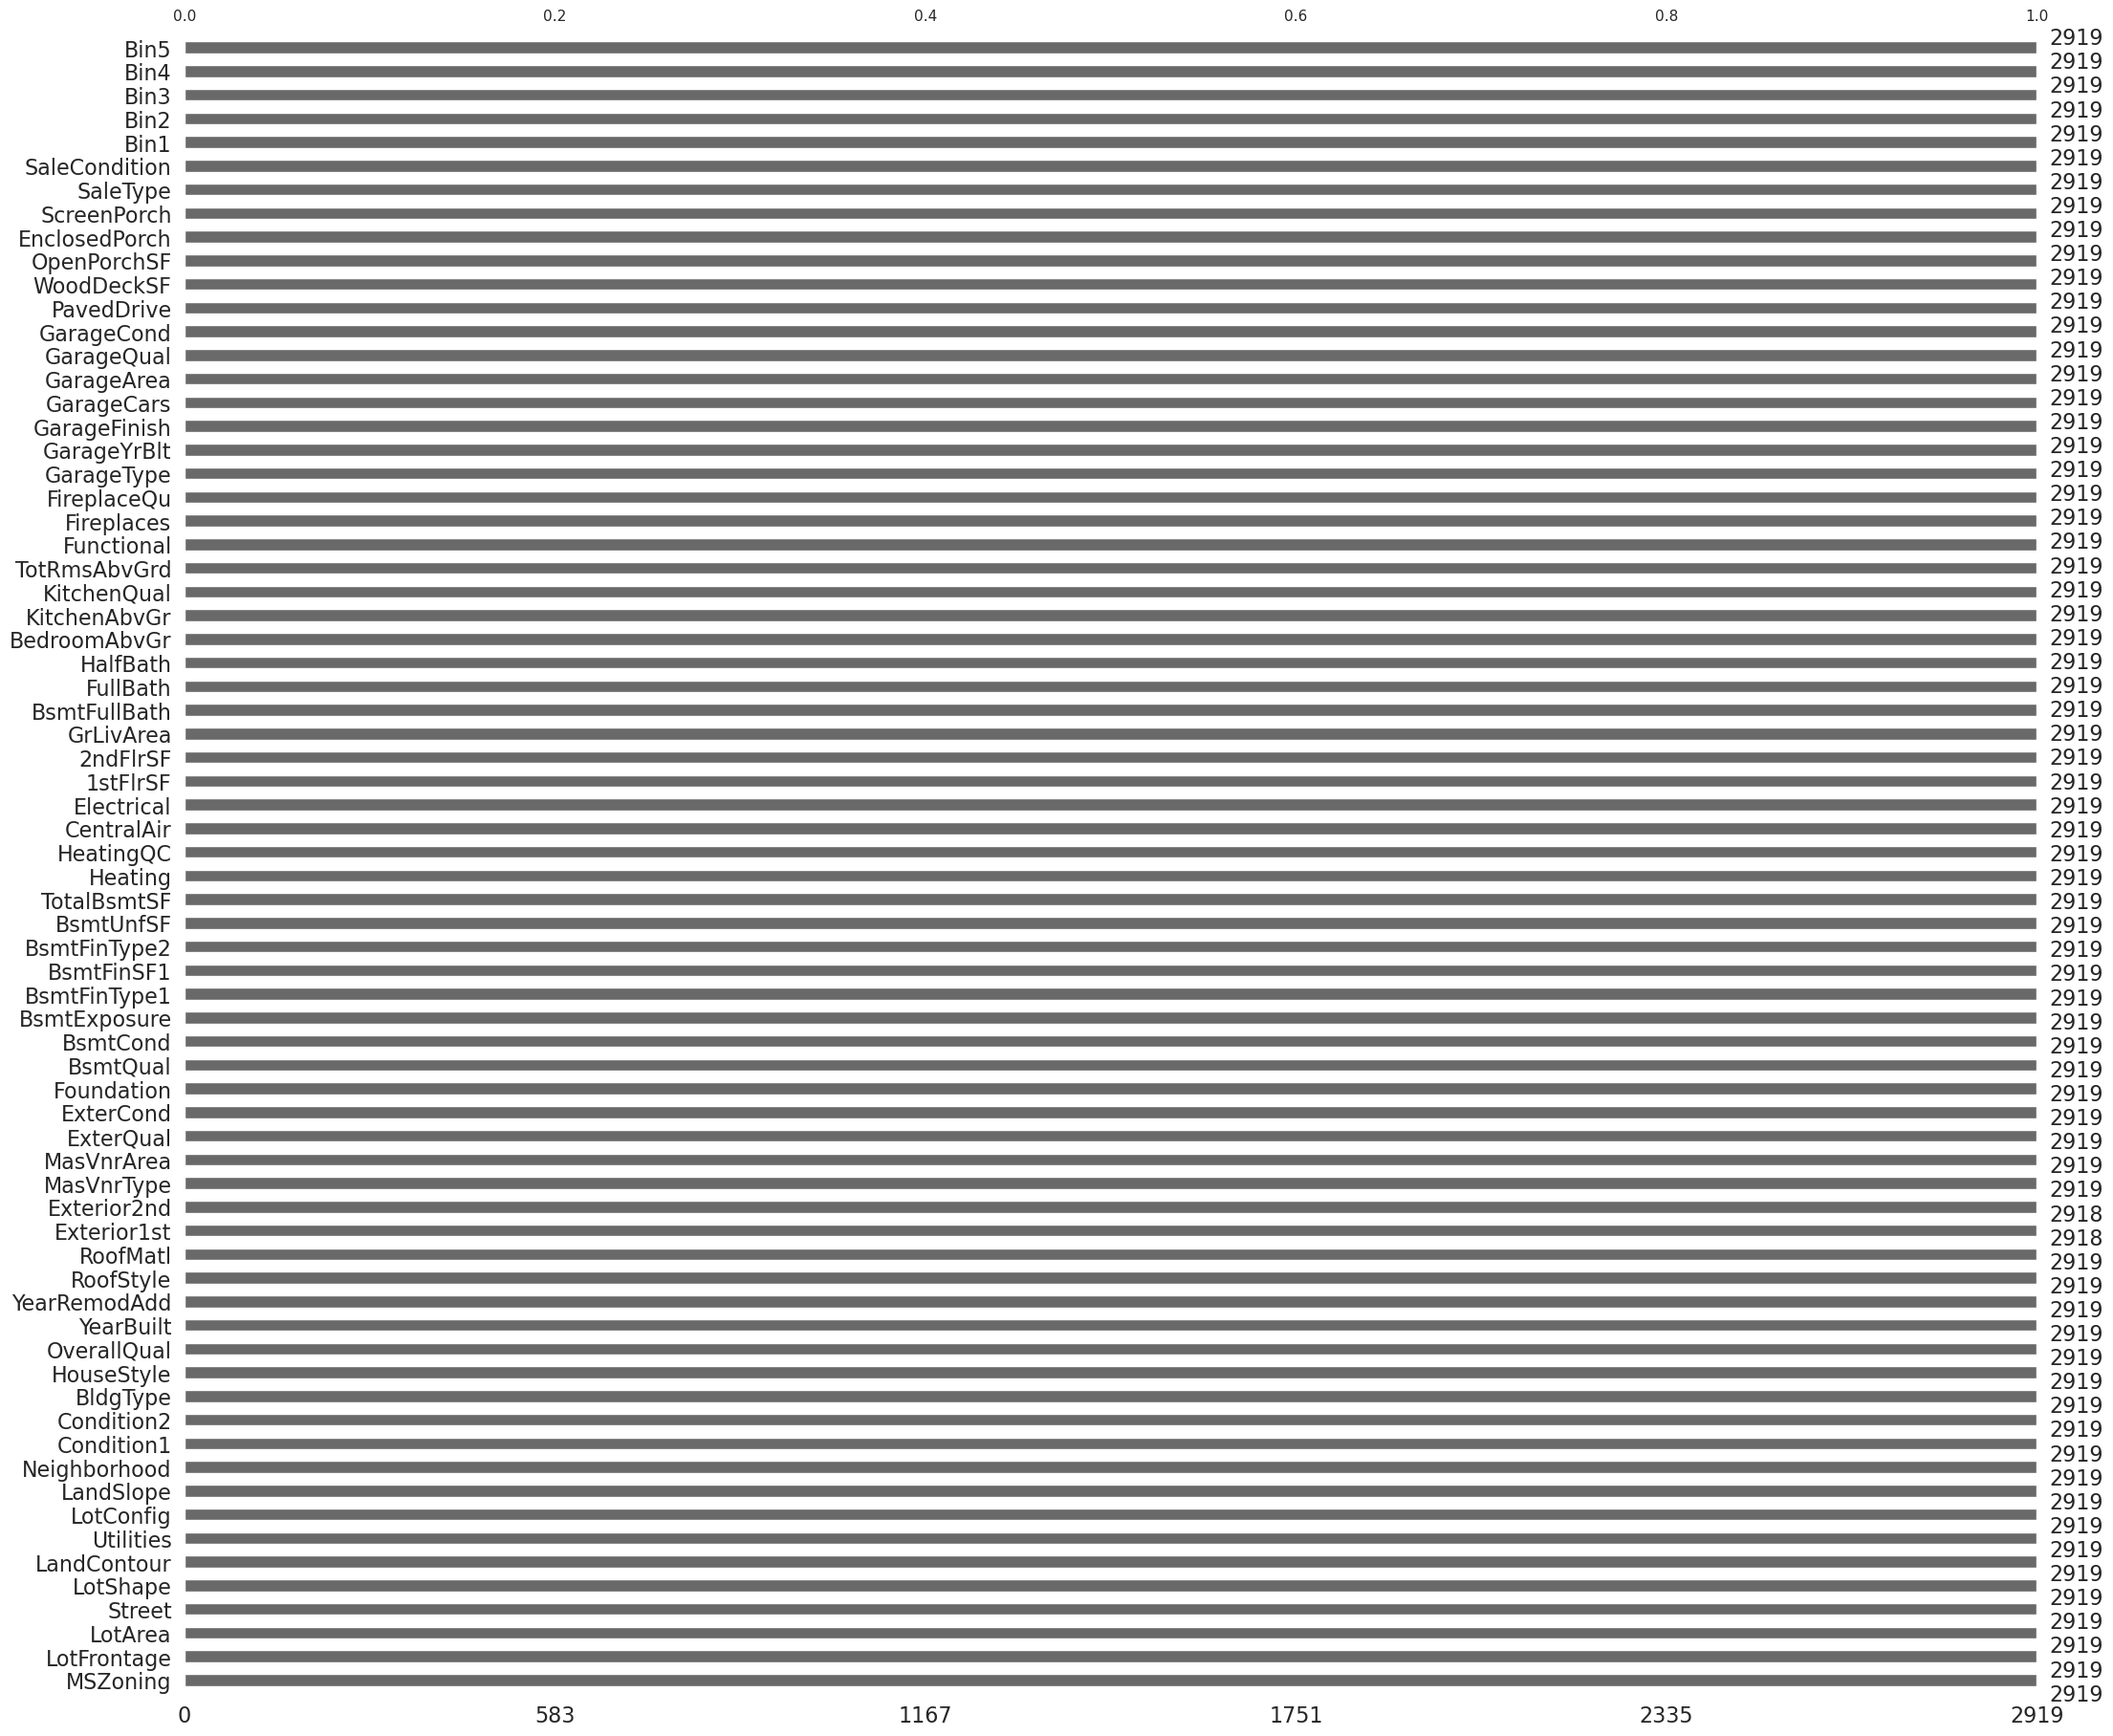

In [23]:
missingno.bar(X)

In [24]:
cat_cols, num_cols, cat_but_car = grab_col_names(X)
for col in cat_cols:
    cat_summary(X, col)

Observations: 2919
Variables: 70
cat_cols: 51
num_cols: 18
cat_but_car: 1
num_but_cat: 13
         MSZoning      Ratio
RL           2269  77.732100
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
##########################################
      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
##########################################
     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
##########################################
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
##########################################
        Utilities      Ratio
AllPub       2918  99.965742
NoSeWa          1   0.034258
##########################################
         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac      

In [25]:
X = rare_encoder(X, 0.01)

In [26]:
X.head()

MSZoning  LotFrontage  LotArea Street LotShape LandContour Utilities  \
Id                                                                        
1        RL         65.0   8450.0   Pave      Reg         Lvl    AllPub   
2        RL         80.0   9600.0   Pave      Reg         Lvl    AllPub   
3        RL         68.0  11250.0   Pave      IR1         Lvl    AllPub   
4        RL         60.0   9550.0   Pave      IR1         Lvl    AllPub   
5        RL         84.0  14260.0   Pave      IR1         Lvl    AllPub   

   LotConfig LandSlope Neighborhood  ... OpenPorchSF EnclosedPorch  \
Id                                   ...                             
1     Inside       Gtl      CollgCr  ...        61.0             0   
2        FR2       Gtl         Rare  ...         0.0             0   
3     Inside       Gtl      CollgCr  ...        42.0             0   
4     Corner       Gtl      Crawfor  ...        35.0           272   
5        FR2       Gtl      NoRidge  ...        84.0             0   

   ScreenPorch SaleType  SaleCondition  Bin1  Bin2 Bin3 Bin4 Bin5  
Id                                                                 
1            0       WD         Normal     D     D    D   B,   B,  
2            0       WD         Normal    B,     C    C    D    D  
3            0       WD         Normal     D     D    D    C   B,  
4            0       WD        Abnorml     D     A    E   B,   B,  
5            0       WD         Normal     E     D    E    D    C  

[5 rows x 70 columns]

In [27]:
for col in cat_cols:
    cat_summary(X, col)

      MSZoning      Ratio
RL        2269  77.732100
RM         460  15.758822
FV         139   4.761905
Rare        51   1.747174
##########################################
      Street    Ratio
Pave    2907  99.5889
Rare      12   0.4111
##########################################
      LotShape      Ratio
Reg       1859  63.686194
IR1        968  33.162042
IR2         76   2.603631
Rare        16   0.548133
##########################################
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
##########################################
        Utilities      Ratio
AllPub       2918  99.965742
Rare            1   0.034258
##########################################
         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
Rare            14   0.479616
##########################################
      Lan

In [28]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

new_df = rare_encoder(X, 0.01)

In [29]:
X=pd.get_dummies(X)

In [30]:
X.head()

LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
Id                                                                           
1          65.0   8450.0          7.0       2003        2003.0       196.0   
2          80.0   9600.0          6.0       1976        1976.0         0.0   
3          68.0  11250.0          7.0       2001        2002.0       162.0   
4          60.0   9550.0          7.0       1915        1970.0         0.0   
5          84.0  14260.0          8.0       2000        2000.0       350.0   

    BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  Bin4_A  Bin4_B,  \
Id                                                ...                    
1        706.0      150.0        856.0     856.0  ...       0        1   
2        978.0      284.0       1262.0    1262.0  ...       0        0   
3        486.0      434.0        920.0     920.0  ...       0        0   
4        216.0      540.0        756.0     961.0  ...       0        1   
5        655.0      490.0       1145.0    1145.0  ...       0        0   

    Bin4_C  Bin4_D  Bin4_E  Bin5_A  Bin5_B,  Bin5_C  Bin5_D  Bin5_E  
Id                                                                   
1        0       0       0       0        1       0       0       0  
2        0       1       0       0        0       0       1       0  
3        1       0       0       0        1       0       0       0  
4        0       0       0       0        1       0       0       0  
5        0       1       0       0        0       1       0       0  

[5 rows x 237 columns]

In [31]:
from scipy.stats import skew

skewed_feats = X[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

EnclosedPorch    2.736178
MasVnrArea       2.057849
OpenPorchSF      1.848880
WoodDeckSF       1.438967
LotArea          1.358129
GrLivArea        1.011270
1stFlrSF         0.961034
BsmtUnfSF        0.919508
BsmtFinSF1       0.903061
2ndFlrSF         0.861675
LotFrontage      0.722704
TotRmsAbvGrd     0.711075
TotalBsmtSF      0.499630
GarageArea       0.241218
OverallQual      0.197110
YearRemodAdd    -0.451020
YearBuilt       -0.599806
GarageYrBlt     -0.630815
dtype: float64

<Axes: xlabel='GrLivArea', ylabel='Density'>

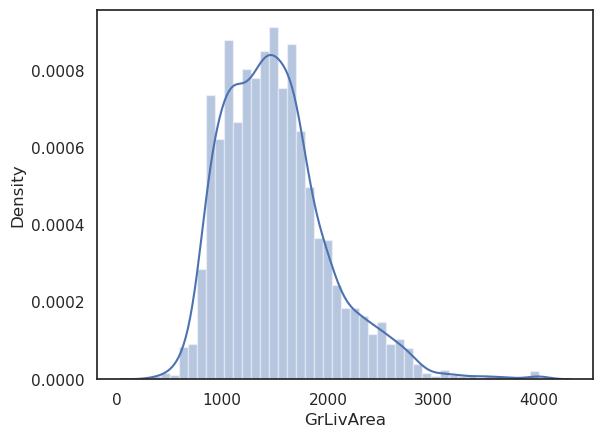

In [32]:
sns.distplot(X['GrLivArea'])

In [33]:
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    

    # Check the skew of all numerical features
    skewed_feats = df[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(X)

<Axes: xlabel='GrLivArea', ylabel='Density'>

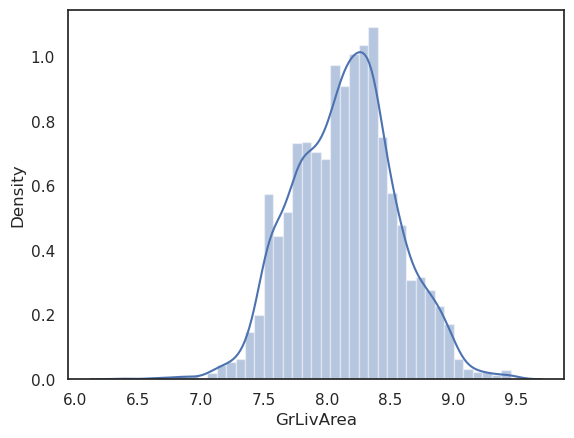

In [34]:
sns.distplot(X['GrLivArea'])

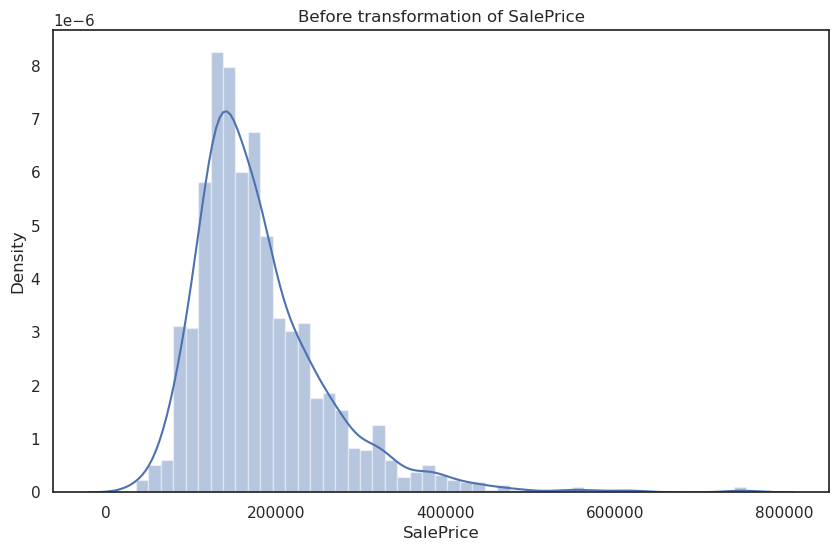

In [35]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(train['SalePrice'])


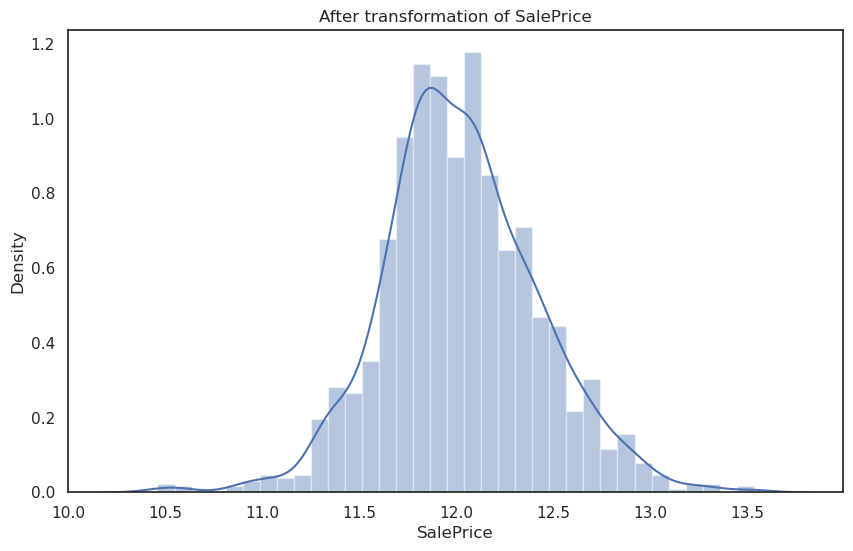

In [36]:
plt.figure(figsize=(10,6))
plt.title("After transformation of SalePrice")
dist = sns.distplot(np.log(train['SalePrice']),norm_hist=False)
y["SalePrice"] = np.log(y['SalePrice'])

In [37]:
cat_cols, num_cols, cat_but_car = grab_col_names(X)
overfit_cat = []
for i in cat_cols:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 98:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

Observations: 2919
Variables: 237
cat_cols: 219
num_cols: 18
cat_but_car: 0
num_but_cat: 219


In [38]:
overfit_num = []
for i in num_cols:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 98:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)


In [39]:
print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['ScreenPorch', 'MSZoning_Rare', 'Street_Pave', 'Street_Rare', 'LotShape_Rare', 'Utilities_AllPub', 'Utilities_Rare', 'LotConfig_Rare', 'LandSlope_Rare', 'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_MeadowV', 'Neighborhood_SWISU', 'Neighborhood_StoneBr', 'Condition1_PosN', 'Condition1_RRAn', 'Condition2_Norm', 'Condition2_Rare', 'HouseStyle_Rare', 'RoofStyle_Rare', 'RoofMatl_CompShg', 'RoofMatl_Rare', 'Exterior1st_AsbShng', 'Exterior1st_Rare', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_BrkFace', 'Exterior2nd_Rare', 'Exterior2nd_Stucco', 'MasVnrType_Rare', 'ExterQual_Fa', 'ExterCond_Rare', 'Foundation_Rare', 'Foundation_Slab', 'BsmtCond_Rare', 'BsmtFinType2_ALQ', 'BsmtFinType2_GLQ', 'Heating_GasA', 'Heating_Rare', 'HeatingQC_Rare', 'Electrical_FuseF', 'Electrical_Rare', 'Functional_Mod', 'Functional_Rare', 'FireplaceQu_Ex', 'FireplaceQu_Po', 'GarageType_Basment', 'GarageType_Rare', '

In [40]:
import re
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X = X.rename(columns=new_names)

In [41]:
x = X.loc[train.index]
y = y.loc[train.index]
test = test.reindex(X.index)
test = X.loc[test.index]

In [42]:
from sklearn.preprocessing import RobustScaler

cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
model = LGBMRegressor()

In [45]:
lgbm = model.fit(X_train, y_train)
preds = lgbm.predict(X_test) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_test, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, preds))
score_lgbm = lgbm.score(X_test, y_test)
cv_lgbm = mean_cross_val(lgbm, x, y)
print("RMSE is",rmse_lgbm)
print("Score is",score_lgbm)
print("MAE is",mae_lgbm)
print("CV(5) is",cv_lgbm)

RMSE is 0.1429204998269271
Score is 0.8823070750261917
MAE is 0.096327359083095
CV(5) is 0.885963625830561


In [46]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [47]:
lgbm_best_grid.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 1000}

In [48]:
lgbm2 = lgbm.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train)
preds = lgbm2.predict(X_test) 
preds_test_lgbm = lgbm2.predict(test)
mae_lgbm = mean_absolute_error(y_test, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, preds))
score_lgbm = lgbm2.score(X_test, y_test)
cv_lgbm = mean_cross_val(lgbm, x, y)
print("RMSE is",rmse_lgbm)
print("Score is",score_lgbm)
print("MAE is",mae_lgbm)
print("CV(5) is",cv_lgbm)

RMSE is 0.13477984970532342
Score is 0.8953326474963039
MAE is 0.08866577929042421
CV(5) is 0.8924309047424519


In [49]:
lgbm = LGBMRegressor(random_state=17, colsample_bytree=0.5, learning_rate=0.01)

lgbm_params = {"n_estimators": [700, 800, 900, 1000, 2000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [50]:
lgbm_best_grid.best_params_

{'n_estimators': 5000}

In [51]:
lgbm_final = lgbm.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train)
preds = lgbm_final.predict(X_test) 
preds_test_lgbm = lgbm_final.predict(test)
mae_lgbm = mean_absolute_error(y_test, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, preds))
score_lgbm = lgbm_final.score(X_test, y_test)
cv_lgbm = mean_cross_val(lgbm_final, x, y)
print("RMSE is",rmse_lgbm)
print("Score is",score_lgbm)
print("MAE is",mae_lgbm)
print("CV(5) is",cv_lgbm)

RMSE is 0.1387632298798582
Score is 0.8890543947818805
MAE is 0.09117331347751445
CV(5) is 0.8911180687812207


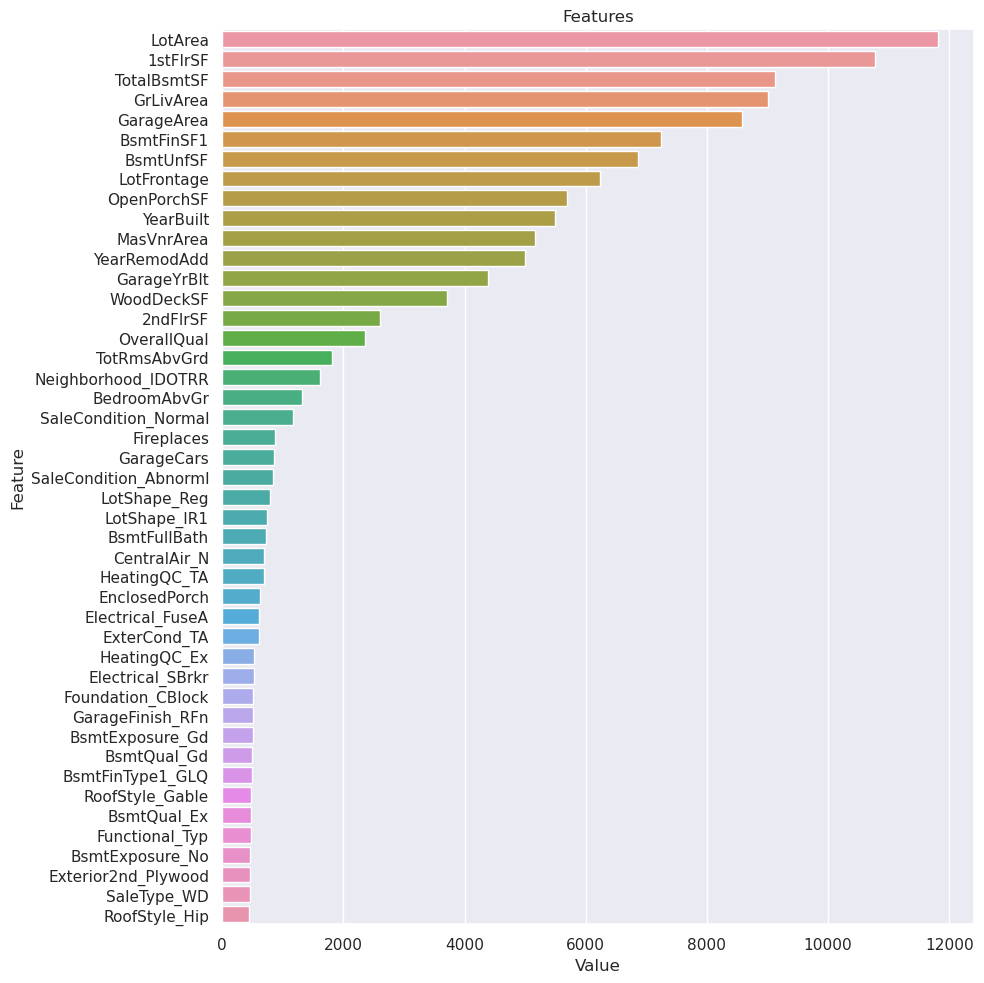

In [52]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(lgbm_final, X,num=45)